# Experiments simulation 5 


## Imports

In [1]:
import os, sys, random, pickle
from datetime import datetime
from zoneinfo import ZoneInfo  
import polars as pl
import pandas as pd
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt  
from sklearn.manifold import MDS
from BigEDA.descriptive import outliers_table
from BigEDA.plots import boxplot_matrix, histogram_matrix, barplot_matrix
from db_robust_clust.plots import clustering_MDS_plot_multiple_methods
from PyDistances.mixed import FastGGowerDistMatrix
from db_robust_clust.models import FastKmedoidsGGower, FoldFastKmedoidsGGower
from sklearn_extra.cluster import KMedoids, CLARA
from sklearn.cluster import (KMeans, AgglomerativeClustering,
                             SpectralBiclustering, SpectralCoclustering, Birch, 
                             BisectingKMeans, MiniBatchKMeans)
from sklearn.mixture import GaussianMixture
from clustpy.partition import SubKmeans, LDAKmeans
from clustpy.hierarchical import Diana
sns.set_style('whitegrid')

current_path = os.getcwd()
src_path = os.path.join(current_path, '..', '..', 'src')
config_path = os.path.join(current_path, '..', '..', 'config')
sys.path.append(src_path)
sys.path.append(config_path)

from simulations_utils import get_simulation_6

from experiments_utils import (make_experiment_1, 
                               make_experiment_3, 
                               make_experiment_4,
                               get_pivoted_results, get_avg_results,
                               get_pivoted_results_two_iterables,
                               get_avg_results_two_iterables,
                               avg_results_to_dfs,
                               get_GGower_distances_names, 
                               split_list_in_chunks)

from config_experiment_1_simulation_6 import get_config as get_config_exp_1_sim_6
from config_experiment_3_simulation_6 import get_config as get_config_exp_3_sim_6
from config_experiment_4_simulation_6 import get_config as get_config_exp_4_sim_6


## Data Simulation

In [15]:
X, y, outliers_idx = get_simulation_6(random_state=123, return_outlier_idx=True)

In [16]:
# polars conversion for data exploration
X_pl = pl.from_pandas(X)

## Data Exploration

In [17]:
X.head()

,X1,X2,X3,X4,X5,X6,X7,X8
0,-11.010788,-35.577322,5.369400,0.119920,0,1,1,1
1,-1.044792,-4.062543,-1.828567,7.173568,0,0,1,2
2,-19.552345,-14.977310,-0.648115,-7.736017,1,1,1,3
3,-5.055414,-4.980831,2.078765,-0.971602,1,1,3,3
4,-3.086783,-15.462055,4.129252,6.076827,1,1,1,1


In [18]:
# Proportion of individuals per cluster/group
unique_values, counts = np.unique(y, return_counts=True)
prop_clusters = counts/len(y)
prop_clusters = {k: v for k, v in zip(unique_values, prop_clusters)}
print(f'prop_clusters: {prop_clusters}')

prop_clusters: {0: 0.3333333333333333, 1: 0.3333333333333333, 2: 0.3333333333333333}


In [19]:
# Outliers information
outliers_table(X_pl, auto=False, col_names=['X1', 'X2', 'X3', 'X4'], h=1.5)

quant_variables,lower_bound,upper_bound,n_outliers,n_not_outliers,prop_outliers,prop_not_outliers
str,f64,f64,i64,i64,f64,f64
"""X1""",-17.545317,14.887238,14103,285897,0.04701,0.95299
"""X2""",-14.126787,4.524058,27826,272174,0.092753,0.907247
"""X3""",-12.105019,6.446671,2770,297230,0.009233,0.990767
"""X4""",-7.126211,10.767268,17243,282757,0.057477,0.942523


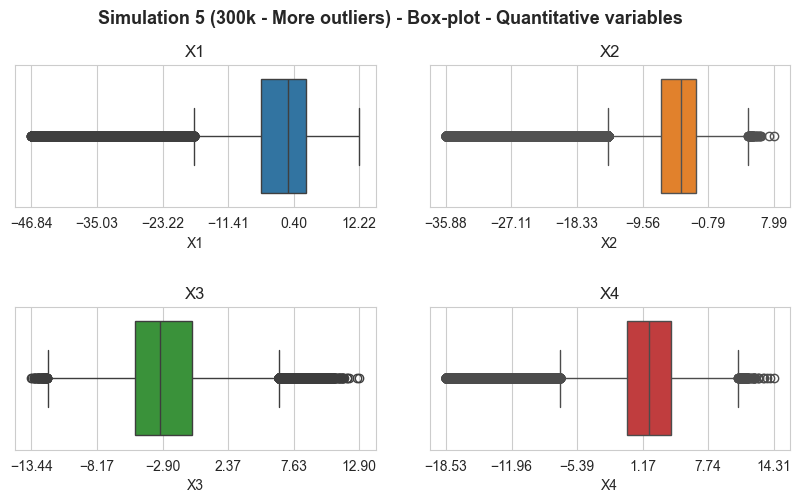

In [20]:
# Boxplot after outliers contamination
boxplot_matrix(X_pl, 
               n_cols=2, 
               title='Simulation 5 (300k - More outliers) - Box-plot - Quantitative variables', 
               figsize=(10,5), 
               quant_col_names=['X1', 'X2', 'X3', 'X4'], 
               n_xticks=6, 
               title_fontsize=13, 
               save=False, 
               file_name='', 
               x_rotation=0, 
               title_height=0.99,
               style='whitegrid', 
               hspace=0.7, 
               wspace=0.15, 
               title_weight='bold',
               subtitles_fontsize=12, 
               xlabel_size=10)

In [21]:
# Boxplot before outliers contamination
'''
boxplot_matrix(X_not_outliers, 
               n_cols=2, 
               title='Box-plot - Quantitative variables - Before outliers contamination', 
               figsize=(10,5), 
               quant_col_names=['X1', 'X2', 'X3', 'X4'], 
               n_xticks=6, 
               title_fontsize=13, 
               save=False, 
               file_name='', 
               x_rotation=0, 
               title_height=0.99,
               style='whitegrid', 
               hspace=0.7, 
               wspace=0.15, 
               title_weight='bold',
               subtitles_fontsize=12, 
               xlabel_size=10)
'''

"\nboxplot_matrix(X_not_outliers, \n               n_cols=2, \n               title='Box-plot - Quantitative variables - Before outliers contamination', \n               figsize=(10,5), \n               quant_col_names=['X1', 'X2', 'X3', 'X4'], \n               n_xticks=6, \n               title_fontsize=13, \n               save=False, \n               file_name='', \n               x_rotation=0, \n               title_height=0.99,\n               style='whitegrid', \n               hspace=0.7, \n               wspace=0.15, \n               title_weight='bold',\n               subtitles_fontsize=12, \n               xlabel_size=10)\n"

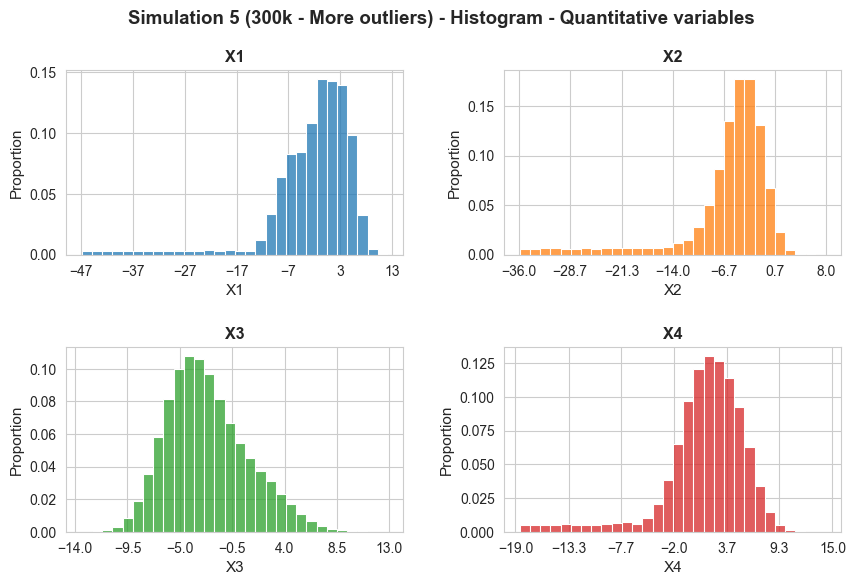

In [22]:
# Histogram
histogram_matrix(df=X_pl, bins=30, n_cols=2, 
                 title='Simulation 5 (300k - More outliers) - Histogram - Quantitative variables', 
                 figsize=(10,6), quant_col_names=['X1', 'X2', 'X3', 'X4'], 
                 n_xticks=7, title_fontsize=13.5, 
                 subtitles_fontsize=11.5, save=False, file_name='', x_rotation=0, title_height=0.98,
                 style='whitegrid', hspace=0.5, wspace=0.3, n_round_xticks=1)

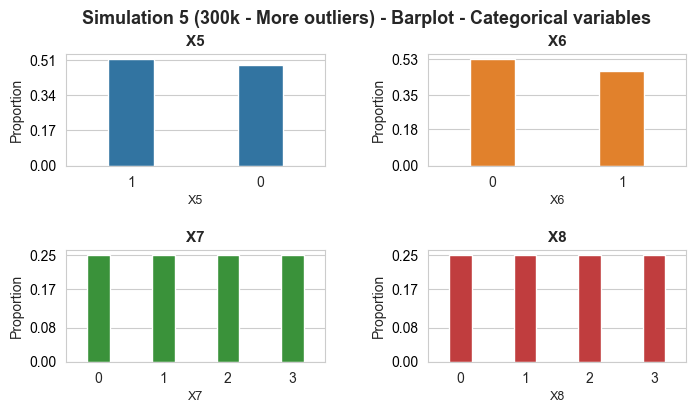

In [23]:
# Barplot
barplot_matrix(df=X_pl, n_cols=2, 
               title='Simulation 5 (300k - More outliers) - Barplot - Categorical variables', 
                 figsize=(8,4), cat_col_names=['X5', 'X6', 'X7', 'X8'], 
                 title_fontsize=13, subtitles_fontsize=11, 
                 save=False, file_name='', x_rotation=0, title_height=0.99,
                 style='whitegrid', hspace=0.75, wspace=0.4, title_weight='bold', bar_width=0.35,
                 ylabel_size=10, xlabel_size=9, xticks_size=10)

In [24]:
# Correlation Matrix
X[['X1', 'X2', 'X3', 'X4']].corr()

,X1,X2,X3,X4
X1,1.000000,0.586454,-0.347701,0.614461
X2,0.586454,1.000000,-0.103623,0.615389
X3,-0.347701,-0.103623,1.000000,-0.061088
X4,0.614461,0.615389,-0.061088,1.000000


In [25]:
# Correlation Analysis
corr_matrix = X[['X1', 'X2', 'X3', 'X4']].corr().to_numpy()
n_corr = len(corr_matrix[np.triu_indices_from(corr_matrix, k=1)])
n_corr_below_30 = np.sum(np.abs(corr_matrix[np.triu_indices_from(corr_matrix, k=1)]) < 0.30)
n_corr_above_60 = np.sum(np.abs(corr_matrix[np.triu_indices_from(corr_matrix, k=1)]) > 0.60)
n_corr_between = np.sum((np.abs(corr_matrix[np.triu_indices_from(corr_matrix, k=1)]) >= 0.30) & (np.abs(corr_matrix[np.triu_indices_from(corr_matrix, k=1)]) <= 0.60))
                        
print('Proportion of pair-wise correlation > 0.60 (in abs. value): ', np.round(n_corr_above_60 / n_corr, 2))
print('Proportion of pair-wise correlations in [0.30, 0.60]: ', np.round(n_corr_between / n_corr, 2))
print('Proportion of pair-wise correlation < 0.30 (in abs. value): ', np.round(n_corr_below_30 / n_corr, 2))

Proportion of pair-wise correlation > 0.60 (in abs. value):  0.33
Proportion of pair-wise correlations in [0.30, 0.60]:  0.33
Proportion of pair-wise correlation < 0.30 (in abs. value):  0.33


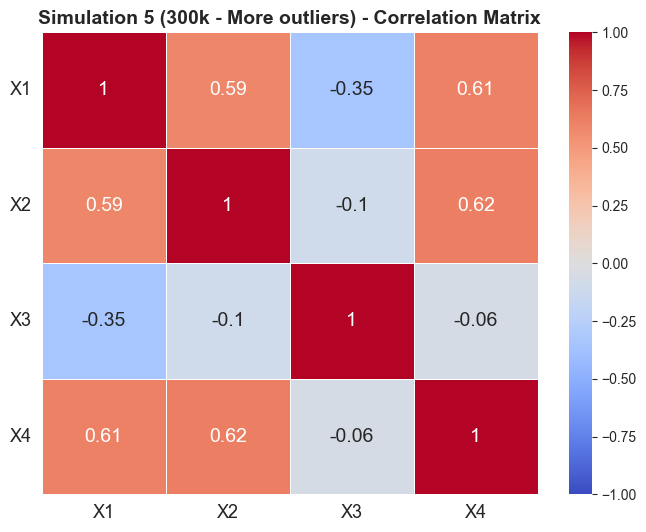

In [26]:
# Matriz de correlaciones
corr = X[['X1', 'X2', 'X3', 'X4']].corr().round(2)

plt.figure(figsize=(8,6))
sns.heatmap(
    corr, 
    annot=True,                 # Muestra los valores dentro de las celdas
    cmap="coolwarm",            # Paleta de colores
    vmin=-1, vmax=1,             # Escala del colorbar
    linewidths=0.5,             # Líneas entre celdas
    annot_kws={"size": 14}      # Tamaño del texto dentro de las celdas
)

# Personalizar etiquetas
plt.xticks(fontsize=13)         # Tamaño etiquetas eje X
plt.yticks(fontsize=13, rotation=0)  # Tamaño etiquetas eje Y (sin rotación)
plt.title("Simulation 5 (300k - More outliers) - Correlation Matrix", fontsize=14, fontweight='bold')
plt.show()

## Experiment 1: Accuracy and computation time for Fast k-medoids (section 3.2)

In [2]:
run_experiment_1 = True

In [ ]:
if run_experiment_1: 
        
    n_realizations = 70
    experiment_random_state = 123 
    random.seed(experiment_random_state)
    random_state_list = random.sample(range(n_realizations*1000), n_realizations)

    chunk_size = 3
    random_state_list_chunks = split_list_in_chunks(random_state_list, chunk_size=chunk_size)

    results_folder_path = os.path.join(current_path, '..', 'results', 'results_experiment_1', 'simulation_6')
    os.makedirs(results_folder_path, exist_ok=True)
    file_id = datetime.now(ZoneInfo("Europe/Madrid")).strftime('%Y%m%d_%H%M%S')

    experiment_1_config = get_config_exp_1_sim_6()

    X, y = get_simulation_6(random_state=experiment_random_state, return_outlier_idx=False)

    for chunk_id, random_state_chunk in enumerate(tqdm(random_state_list_chunks, desc='chunks', unit='chunks'), start=0):
        print("chunk_id:", chunk_id)
        print('random_state_chunk:', random_state_chunk)

        results = {}

        for random_state in random_state_chunk:
            print('random_state:', random_state)
                
            results[random_state] = make_experiment_1(**experiment_1_config,
                                                      X=X, 
                                                      y=y,
                                                      random_state=random_state)
            
        # Save results
        results_filename = f'results_exp_1_simu_6_chunk_{chunk_id}_{file_id}.pkl'
        results_save_path = os.path.join(results_folder_path, results_filename)
        with open(results_save_path, 'wb') as f:
            pickle.dump(results, f)

# Time 70 realization 
## IBiDat Server: 2729 mins =  hours

chunks:   0%|          | 0/19 [00:00<?, ?chunks/s]

chunk_id: 5
random_state_chunk: [32134, 21466, 218]
random_state: 32134
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
random_state: 21466
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
random_state: 218
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2


chunks:   5%|▌         | 1/19 [1:15:37<22:41:11, 4537.29s/chunks]

chunk_id: 6
random_state_chunk: [57183, 11483, 49492]
random_state: 57183
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
random_state: 11483
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
random_state: 49492
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2


chunks:  11%|█         | 2/19 [2:38:16<22:35:50, 4785.33s/chunks]

chunk_id: 7
random_state_chunk: [9158, 864, 41347]
random_state: 9158
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
random_state: 864
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
random_state: 41347
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2


chunks:  16%|█▌        | 3/19 [3:55:25<20:57:03, 4713.99s/chunks]

chunk_id: 8
random_state_chunk: [58762, 13374, 5752]
random_state: 58762
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
random_state: 13374
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
random_state: 5752
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2


chunks:  21%|██        | 4/19 [5:13:58<19:38:23, 4713.58s/chunks]

chunk_id: 9
random_state_chunk: [12158, 18635, 16547]
random_state: 12158
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
random_state: 18635
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
random_state: 16547
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2


chunks:  26%|██▋       | 5/19 [7:06:26<21:11:01, 5447.23s/chunks]

chunk_id: 10
random_state_chunk: [2783, 38247, 56444]
random_state: 2783
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
random_state: 38247
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
random_state: 56444
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2


chunks:  32%|███▏      | 6/19 [9:00:11<21:21:42, 5915.57s/chunks]

chunk_id: 11
random_state_chunk: [62511, 34776, 61511]
random_state: 62511
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
random_state: 34776
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
random_state: 61511
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2


chunks:  37%|███▋      | 7/19 [11:57:36<24:52:20, 7461.72s/chunks]

chunk_id: 12
random_state_chunk: [4816, 39989, 45018]
random_state: 4816
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
random_state: 39989
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
random_state: 45018
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2


chunks:  42%|████▏     | 8/19 [15:03:41<26:24:08, 8640.79s/chunks]

chunk_id: 13
random_state_chunk: [68376, 63302, 27113]
random_state: 68376
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
random_state: 63302
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
random_state: 27113
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2


chunks:  47%|████▋     | 9/19 [18:01:07<25:44:36, 9267.67s/chunks]

chunk_id: 14
random_state_chunk: [69084, 41322, 1644]
random_state: 69084
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
random_state: 41322
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
random_state: 1644
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2


chunks:  53%|█████▎    | 10/19 [20:55:43<24:06:07, 9640.87s/chunks]

chunk_id: 15
random_state_chunk: [52197, 67207, 56935]
random_state: 52197
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
random_state: 67207
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
random_state: 56935
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2


chunks:  58%|█████▊    | 11/19 [23:44:58<21:46:24, 9798.04s/chunks]

chunk_id: 16
random_state_chunk: [63718, 68237, 54984]
random_state: 63718
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
random_state: 68237
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
random_state: 54984
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2


chunks:  63%|██████▎   | 12/19 [26:39:37<19:27:15, 10005.11s/chunks]

chunk_id: 17
random_state_chunk: [49089, 66855, 4173]
random_state: 49089
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
random_state: 66855
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
random_state: 4173
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2


chunks:  68%|██████▊   | 13/19 [30:19:25<18:16:56, 10969.38s/chunks]

chunk_id: 18
random_state_chunk: [23784, 10827, 63819]
random_state: 23784
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
random_state: 10827
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
random_state: 63819
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2


chunks:  74%|███████▎  | 14/19 [33:04:29<14:47:18, 10647.68s/chunks]

chunk_id: 19
random_state_chunk: [34326, 22298, 43896]
random_state: 34326
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
random_state: 22298
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
random_state: 43896
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2


chunks:  79%|███████▉  | 15/19 [35:59:30<11:46:53, 10603.38s/chunks]

chunk_id: 20
random_state_chunk: [44160, 51274, 9606]
random_state: 44160
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
random_state: 51274
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
random_state: 9606
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2


chunks:  84%|████████▍ | 16/19 [38:44:49<8:39:52, 10397.50s/chunks] 

chunk_id: 21
random_state_chunk: [59869, 50810, 44054]
random_state: 59869
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
random_state: 50810
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
random_state: 44054
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2


chunks:  89%|████████▉ | 17/19 [41:32:35<5:43:15, 10297.88s/chunks]

chunk_id: 22
random_state_chunk: [2137, 24780, 11554]
random_state: 2137
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
random_state: 24780
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
random_state: 11554
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2


chunks:  95%|█████████▍| 18/19 [44:36:59<2:55:28, 10528.03s/chunks]

chunk_id: 23
random_state_chunk: [47646]
random_state: 47646
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2


chunks: 100%|██████████| 19/19 [45:29:54<00:00, 8620.74s/chunks]   


In [ ]:
if run_experiment_1: 

    # Open results by chunk
    chunk_ids = range(len(random_state_list_chunks))
    results_chunk = {}
    results_folder_path = os.path.join(current_path, '..', '..', 'results', 'results_experiment_1', 'simulation_6')
    for chunk_id in chunk_ids:
        if chunk_id < 5:
            file_id = '20250804_200116'
        else:
            file_id = '20250805_120409'
        results_filename = f'results_exp_1_simu_6_chunk_{chunk_id}_{file_id}.pkl'
        results_save_path = os.path.join(results_folder_path, results_filename)
        with open(results_save_path, 'rb') as f:
            results_chunk[chunk_id] = pickle.load(f)

    # Join results by chunks
    results = {}
    for i in chunk_ids:
        results.update(results_chunk[i])  

    # Save joined/merged results 
    results_filename = f'results_exp_1_simu_6_{file_id}.pkl'
    results_save_path = os.path.join(results_folder_path, results_filename)
    with open(results_save_path, 'wb') as f:
        pickle.dump(results, f)

In [4]:
# Open merged/joined results 
file_id = '20250805_120409'
results_filename = f'results_exp_1_simu_6_{file_id}.pkl'
results_folder_path = os.path.join(current_path, '..', '..', 'results', 'results_experiment_1', 'simulation_5')
results_save_path = os.path.join(results_folder_path, results_filename)
with open(results_save_path, 'rb') as f:
    results = pickle.load(f)

In [5]:
experiment_1_config = get_config_exp_1_sim_6()

pivoted_results = get_pivoted_results(
    results=results, 
    iterable=experiment_1_config['frac_sample_sizes']
)

avg_results = get_avg_results(
    results=results, 
    pivoted_results=pivoted_results, 
    iterable=experiment_1_config['frac_sample_sizes']
)

In [6]:
frac_sample_sizes_list = np.array(list(avg_results['adj_accuracy'].keys()))
adj_accuracy_list = list(avg_results['adj_accuracy'].values())
ari_list = list(avg_results['ARI'].values())
time_list = list(avg_results['time'].values())
best_frac_sample_size = frac_sample_sizes_list[np.argmax(adj_accuracy_list)]

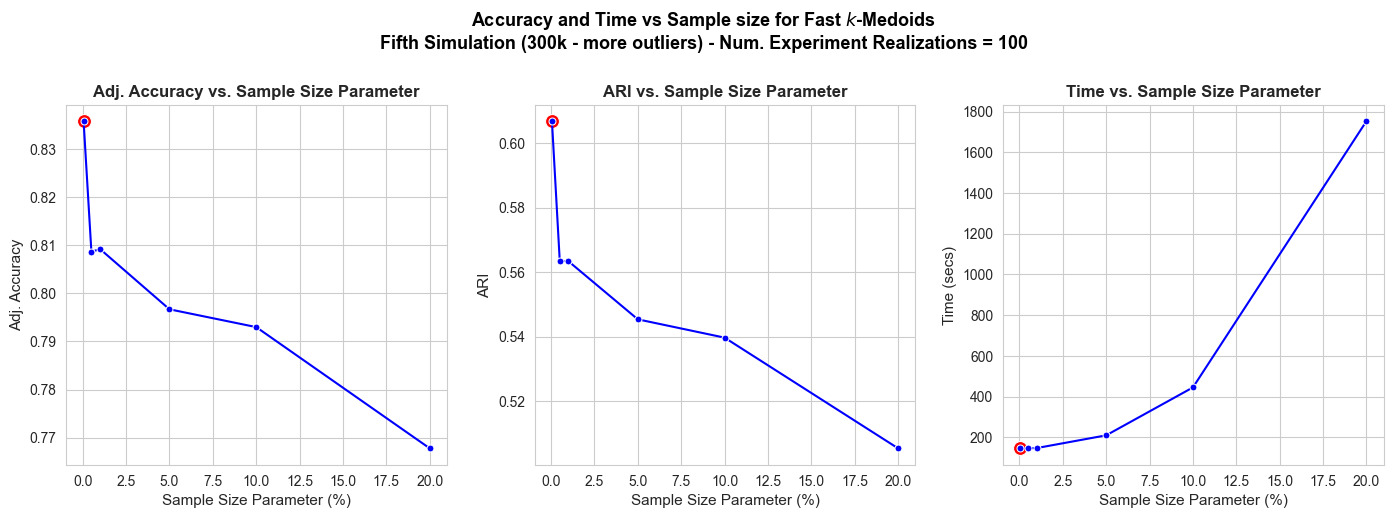

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(17,5))
axes = axes.flatten()  

sns.lineplot(x=[best_frac_sample_size * 100], y=[avg_results['adj_accuracy'][best_frac_sample_size]], color='red', marker='o',  markersize=10, ax=axes[0])
sns.lineplot(
    x=frac_sample_sizes_list * 100,
    y=adj_accuracy_list, 
    color='blue', marker='o',  markersize=5, ax=axes[0]
)

sns.lineplot(x=[best_frac_sample_size * 100], y=[avg_results['ARI'][best_frac_sample_size]], color='red', marker='o',  markersize=10, ax=axes[1])
sns.lineplot(
    x=frac_sample_sizes_list * 100,
    y=ari_list, 
    color='blue', marker='o',  markersize=5, ax=axes[1]
)

sns.lineplot(x=[best_frac_sample_size * 100], y=[avg_results['time'][best_frac_sample_size]], color='red', marker='o', markersize=10, ax=axes[2])
sns.lineplot(
    x=frac_sample_sizes_list * 100,
    y=time_list, 
    color='blue', marker='o', markersize=5, ax=axes[2]
)

axes[0].set_title('Adj. Accuracy vs. Sample Size Parameter', size=12, weight='bold')
axes[0].set_ylabel('Adj. Accuracy', size=11)
#axes[0].set_yticks(np.round(np.linspace(np.min(best_accuracy_values), np.max(best_accuracy_values), 7),3))

axes[1].set_title('ARI vs. Sample Size Parameter', size=12, weight='bold')
axes[1].set_ylabel('ARI', size=11)
#axes[1].set_yticks(np.round(np.linspace(np.min(best_accuracy_values), np.max(best_accuracy_values), 7),3))

axes[2].set_title('Time vs. Sample Size Parameter', size=12, weight='bold')
axes[2].set_ylabel('Time (secs)', size=11)
#axes[2].set_yticks(np.round(np.linspace(np.min(times_values), np.max(times_values), 7),1))

for i in range(len(axes)):
    #axes[i].set_xticks(np.round(np.linspace(np.min(data_perc_sizes), np.max(data_perc_sizes), 7),1))
    axes[i].set_xlabel('Sample Size Parameter (%)', size=11)

#plt.tight_layout()
plt.subplots_adjust(top=0.83)
plt.suptitle('Accuracy and Time vs Sample Size Parameter for Fast $k$-Medoids\nFifth Simulation (300k - more outliers) - Num. Experiment Realizations = 100', fontsize=13, y=1.02, weight='bold', color='black', alpha=1)
plt.subplots_adjust(hspace=0.5, wspace=0.23) 

plot_filename = f'plot_results_exp_1_simu_6_{file_id}.png'
plot_save_path = os.path.join(results_folder_path, plot_filename)
fig.savefig(plot_save_path, format='png', dpi=300, bbox_inches="tight", pad_inches=0.2)

plt.show()

In [9]:
# Results as table 
avg_results_df = pd.DataFrame(avg_results)
avg_results_df.index.name = 'frac_sample_size'
avg_results_df

,time,adj_accuracy,ARI
frac_sample_size,,,
0.0005,145.278463,0.835853,0.606871
0.0050,145.657615,0.808660,0.563472
0.0100,146.837934,0.809224,0.563369
0.0500,209.274735,0.796693,0.545334
0.1000,444.725325,0.792993,0.539656
0.2000,1753.123482,0.767766,0.505293


In [10]:
print(best_frac_sample_size)

0.0005



## Experiment 3: Accuracy, computation time and number of folds for q-Fold Fast k-medoids

In [3]:
run_experiment_3 = True

In [ ]:
if run_experiment_3: 

    n_realizations = 70
    experiment_random_state = 123 
    random.seed(experiment_random_state)
    random_state_list = random.sample(range(n_realizations*1000), n_realizations)

    chunk_size = 3
    random_state_list_chunks = split_list_in_chunks(random_state_list, chunk_size=chunk_size)

    results_folder_path = os.path.join(current_path, '..', '..', 'results', 'results_experiment_3', 'simulation_6')
    os.makedirs(results_folder_path, exist_ok=True)
    file_id = datetime.now(ZoneInfo("Europe/Madrid")).strftime('%Y%m%d_%H%M%S')

    experiment_3_config = get_config_exp_3_sim_6()

    X, y = get_simulation_6(random_state=experiment_random_state, return_outlier_idx=False)

    for chunk_id, random_state_chunk in enumerate(tqdm(random_state_list_chunks), start=0):
        print('random_state_chunk:', random_state_chunk)

        if chunk_id not in list(range(5,11)):

            results = {}

            for random_state in random_state_chunk:
                print('random_state:', random_state)    

                results[random_state] = make_experiment_3(**experiment_3_config,
                                                        X=X, 
                                                        y=y,
                                                        random_state=random_state)

            # Save results
            results_filename = f'results_exp_3_simu_6_chunk_{chunk_id}_{file_id}.pkl'
            results_save_path = os.path.join(results_folder_path, results_filename)
            with open(results_save_path, 'wb') as f:
                pickle.dump(results, f)

# Time 70 realization
## IBiDat Server:  mins =  hours

  0%|          | 0/8 [00:00<?, ?it/s]

random_state_chunk: [63718, 68237, 54984]
random_state: 63718
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:31<00:00, 18.33s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:35<00:00, 19.14s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [02:00<00:00, 24.06s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [02:44<00:00, 32.94s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:33<00:00,  9.39s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.26s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [01:41<00:00, 10.17s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [01:56<00:00, 11.68s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [01:36<00:00,  4.81s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:33<00:00,  4.68s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:34<00:00,  4.75s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [01:42<00:00,  5.12s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [01:43<00:00,  2.58s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [01:39<00:00,  2.50s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [01:37<00:00,  2.43s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 40/40 [01:37<00:00,  2.43s/it]


random_state: 68237
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:32<00:00, 18.41s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:36<00:00, 19.27s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [02:03<00:00, 24.76s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [02:39<00:00, 31.96s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:33<00:00,  9.33s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.29s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [01:41<00:00, 10.15s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [01:57<00:00, 11.78s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [01:37<00:00,  4.86s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:33<00:00,  4.69s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:35<00:00,  4.77s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [01:42<00:00,  5.11s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [01:41<00:00,  2.53s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [01:40<00:00,  2.51s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [01:37<00:00,  2.43s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 40/40 [01:37<00:00,  2.44s/it]


random_state: 54984
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:31<00:00, 18.27s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:35<00:00, 19.08s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [01:57<00:00, 23.40s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [02:44<00:00, 32.98s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.30s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.26s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [01:40<00:00, 10.03s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [01:59<00:00, 11.97s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [01:36<00:00,  4.83s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:35<00:00,  4.79s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:35<00:00,  4.77s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [01:41<00:00,  5.06s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [01:41<00:00,  2.53s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [01:40<00:00,  2.51s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [01:37<00:00,  2.43s/it]


frac_sample_size: 0.15


 12%|█▎        | 1/8 [1:23:31<9:44:39, 5011.37s/it]

random_state_chunk: [49089, 66855, 4173]
random_state: 49089
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:31<00:00, 18.31s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:36<00:00, 19.34s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [01:55<00:00, 23.08s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [02:39<00:00, 31.89s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:33<00:00,  9.32s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.28s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [01:41<00:00, 10.17s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [01:56<00:00, 11.62s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [01:36<00:00,  4.82s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:33<00:00,  4.68s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:35<00:00,  4.78s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [01:43<00:00,  5.17s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [01:43<00:00,  2.59s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [01:40<00:00,  2.52s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [01:37<00:00,  2.44s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 40/40 [01:37<00:00,  2.44s/it]


random_state: 66855
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:31<00:00, 18.28s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:36<00:00, 19.29s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [01:56<00:00, 23.33s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [02:28<00:00, 29.78s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:33<00:00,  9.31s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.28s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [01:41<00:00, 10.19s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [01:59<00:00, 11.96s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [01:36<00:00,  4.82s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:33<00:00,  4.67s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:35<00:00,  4.77s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [01:41<00:00,  5.07s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [01:43<00:00,  2.58s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [01:39<00:00,  2.50s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [01:37<00:00,  2.43s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 40/40 [01:37<00:00,  2.44s/it]


random_state: 4173
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:31<00:00, 18.28s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:36<00:00, 19.21s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [01:58<00:00, 23.68s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [02:34<00:00, 30.91s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:33<00:00,  9.33s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.27s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [01:41<00:00, 10.15s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [01:59<00:00, 11.97s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [01:36<00:00,  4.82s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:33<00:00,  4.68s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:35<00:00,  4.77s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [01:43<00:00,  5.18s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [01:43<00:00,  2.59s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [01:40<00:00,  2.50s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [01:37<00:00,  2.44s/it]


frac_sample_size: 0.15


 25%|██▌       | 2/8 [2:46:36<8:19:37, 4996.20s/it]

random_state_chunk: [23784, 10827, 63819]
random_state: 23784
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:31<00:00, 18.31s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:36<00:00, 19.29s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [02:00<00:00, 24.20s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [02:34<00:00, 30.89s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:33<00:00,  9.34s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:33<00:00,  9.35s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [01:40<00:00, 10.04s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [01:55<00:00, 11.51s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [01:37<00:00,  4.85s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:34<00:00,  4.74s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:34<00:00,  4.74s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [01:44<00:00,  5.20s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [01:45<00:00,  2.63s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [01:41<00:00,  2.53s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [01:37<00:00,  2.43s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 40/40 [01:38<00:00,  2.45s/it]


random_state: 10827
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:33<00:00, 18.76s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:36<00:00, 19.24s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [02:09<00:00, 25.94s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [02:39<00:00, 31.91s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:33<00:00,  9.35s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:33<00:00,  9.30s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [01:42<00:00, 10.27s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [02:02<00:00, 12.21s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [01:36<00:00,  4.85s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:34<00:00,  4.70s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:35<00:00,  4.76s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [01:45<00:00,  5.26s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [01:44<00:00,  2.61s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [01:40<00:00,  2.52s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [01:36<00:00,  2.42s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 40/40 [01:37<00:00,  2.45s/it]


random_state: 63819
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:31<00:00, 18.25s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:36<00:00, 19.23s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [01:55<00:00, 23.09s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [02:29<00:00, 29.82s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:33<00:00,  9.31s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:33<00:00,  9.35s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [01:41<00:00, 10.11s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [02:00<00:00, 12.02s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [01:36<00:00,  4.82s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:33<00:00,  4.70s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:35<00:00,  4.77s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [01:42<00:00,  5.15s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [01:43<00:00,  2.58s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [01:40<00:00,  2.51s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [01:36<00:00,  2.42s/it]


frac_sample_size: 0.15


 38%|███▊      | 3/8 [4:10:11<6:57:03, 5004.64s/it]

random_state_chunk: [34326, 22298, 43896]
random_state: 34326
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:31<00:00, 18.40s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:36<00:00, 19.23s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [01:55<00:00, 23.15s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [02:39<00:00, 31.94s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:33<00:00,  9.39s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:33<00:00,  9.32s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [01:42<00:00, 10.25s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [01:58<00:00, 11.88s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [01:36<00:00,  4.84s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:33<00:00,  4.68s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:35<00:00,  4.76s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [01:41<00:00,  5.06s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [01:43<00:00,  2.58s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [01:40<00:00,  2.50s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [01:37<00:00,  2.44s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 40/40 [01:37<00:00,  2.45s/it]


random_state: 22298
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:31<00:00, 18.28s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:36<00:00, 19.31s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [02:00<00:00, 24.03s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [02:31<00:00, 30.29s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:33<00:00,  9.33s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:33<00:00,  9.30s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [01:41<00:00, 10.19s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [01:58<00:00, 11.86s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [01:36<00:00,  4.82s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:33<00:00,  4.68s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:35<00:00,  4.77s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [01:41<00:00,  5.09s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [01:43<00:00,  2.59s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [01:39<00:00,  2.50s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [01:37<00:00,  2.43s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 40/40 [01:37<00:00,  2.43s/it]


random_state: 43896
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:31<00:00, 18.29s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:36<00:00, 19.22s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [01:57<00:00, 23.59s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [02:36<00:00, 31.39s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:33<00:00,  9.33s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.27s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [01:40<00:00, 10.07s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [01:59<00:00, 11.92s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [01:36<00:00,  4.83s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:33<00:00,  4.68s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:35<00:00,  4.79s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [01:41<00:00,  5.09s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [01:43<00:00,  2.58s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [01:40<00:00,  2.51s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [01:36<00:00,  2.42s/it]


frac_sample_size: 0.15


 50%|█████     | 4/8 [5:33:22<5:33:16, 4999.11s/it]

random_state_chunk: [44160, 51274, 9606]
random_state: 44160
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:31<00:00, 18.32s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:35<00:00, 19.11s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [01:59<00:00, 23.86s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [02:37<00:00, 31.56s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:33<00:00,  9.31s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.28s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [01:41<00:00, 10.15s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [01:59<00:00, 11.99s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [01:36<00:00,  4.81s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:33<00:00,  4.69s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:35<00:00,  4.77s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [01:42<00:00,  5.11s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [01:44<00:00,  2.60s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [01:40<00:00,  2.50s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [01:36<00:00,  2.42s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 40/40 [01:37<00:00,  2.43s/it]


random_state: 51274
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:31<00:00, 18.23s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:36<00:00, 19.27s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [01:58<00:00, 23.71s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [02:28<00:00, 29.70s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:33<00:00,  9.30s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.27s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [01:41<00:00, 10.20s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [01:58<00:00, 11.87s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [01:36<00:00,  4.81s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:33<00:00,  4.67s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:34<00:00,  4.74s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [01:41<00:00,  5.07s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [01:42<00:00,  2.57s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [01:40<00:00,  2.50s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [01:36<00:00,  2.41s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 40/40 [01:37<00:00,  2.43s/it]


random_state: 9606
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:31<00:00, 18.25s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:35<00:00, 19.05s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [01:58<00:00, 23.71s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [02:36<00:00, 31.25s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:33<00:00,  9.30s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.27s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [01:40<00:00, 10.03s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [01:56<00:00, 11.66s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [01:36<00:00,  4.81s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:33<00:00,  4.68s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:35<00:00,  4.79s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [01:42<00:00,  5.11s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [01:43<00:00,  2.58s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [01:40<00:00,  2.50s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [01:36<00:00,  2.42s/it]


frac_sample_size: 0.15


 62%|██████▎   | 5/8 [6:56:19<4:09:34, 4991.34s/it]

random_state_chunk: [59869, 50810, 44054]
random_state: 59869
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:31<00:00, 18.27s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:35<00:00, 19.09s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [01:57<00:00, 23.51s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [02:33<00:00, 30.65s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.30s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.28s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [01:41<00:00, 10.12s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [01:57<00:00, 11.74s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [01:36<00:00,  4.82s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:33<00:00,  4.66s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:35<00:00,  4.76s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [01:42<00:00,  5.13s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [01:42<00:00,  2.57s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [01:40<00:00,  2.52s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [01:36<00:00,  2.42s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 40/40 [01:37<00:00,  2.44s/it]


random_state: 50810
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:31<00:00, 18.26s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:36<00:00, 19.27s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [01:56<00:00, 23.27s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [02:36<00:00, 31.25s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.30s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.26s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [01:41<00:00, 10.15s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [01:57<00:00, 11.75s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [01:36<00:00,  4.81s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:33<00:00,  4.68s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:34<00:00,  4.75s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [01:41<00:00,  5.10s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [01:43<00:00,  2.59s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [01:40<00:00,  2.50s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [01:36<00:00,  2.42s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 40/40 [01:37<00:00,  2.43s/it]


random_state: 44054
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:31<00:00, 18.28s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:34<00:00, 18.91s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [01:55<00:00, 23.04s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [02:33<00:00, 30.77s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:33<00:00,  9.32s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.29s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [01:42<00:00, 10.22s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [02:00<00:00, 12.09s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [01:36<00:00,  4.84s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:33<00:00,  4.67s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:35<00:00,  4.78s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [01:42<00:00,  5.12s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [01:43<00:00,  2.58s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [01:39<00:00,  2.50s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [01:36<00:00,  2.42s/it]


frac_sample_size: 0.15


 75%|███████▌  | 6/8 [8:19:13<2:46:10, 4985.38s/it]

random_state_chunk: [2137, 24780, 11554]
random_state: 2137
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:31<00:00, 18.30s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:35<00:00, 19.13s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [01:54<00:00, 22.82s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [02:37<00:00, 31.47s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:33<00:00,  9.32s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.27s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [01:42<00:00, 10.20s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [01:58<00:00, 11.87s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [01:36<00:00,  4.84s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:33<00:00,  4.69s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:35<00:00,  4.78s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [01:43<00:00,  5.16s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [01:43<00:00,  2.58s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [01:39<00:00,  2.50s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [01:36<00:00,  2.42s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 40/40 [01:37<00:00,  2.43s/it]


random_state: 24780
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:31<00:00, 18.27s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:35<00:00, 19.05s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [01:54<00:00, 22.87s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [02:39<00:00, 31.99s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:33<00:00,  9.32s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.27s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [01:40<00:00, 10.07s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [01:59<00:00, 11.98s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [01:36<00:00,  4.82s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:33<00:00,  4.68s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:35<00:00,  4.77s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [01:40<00:00,  5.04s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [01:42<00:00,  2.57s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [01:40<00:00,  2.51s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [01:36<00:00,  2.42s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 40/40 [01:37<00:00,  2.43s/it]


random_state: 11554
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:31<00:00, 18.30s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:35<00:00, 19.13s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [01:59<00:00, 23.81s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [02:37<00:00, 31.43s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:33<00:00,  9.32s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.24s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [01:41<00:00, 10.15s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [01:58<00:00, 11.86s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [01:36<00:00,  4.82s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:33<00:00,  4.69s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:35<00:00,  4.76s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [01:42<00:00,  5.12s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [01:43<00:00,  2.58s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [01:40<00:00,  2.51s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [01:37<00:00,  2.43s/it]


frac_sample_size: 0.15


 88%|████████▊ | 7/8 [9:42:19<1:23:05, 4985.48s/it]

random_state_chunk: [47646]
random_state: 47646
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:31<00:00, 18.30s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:35<00:00, 19.17s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [02:00<00:00, 24.02s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 5/5 [02:36<00:00, 31.23s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.30s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.25s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [01:41<00:00, 10.12s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 10/10 [01:59<00:00, 11.95s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [01:36<00:00,  4.84s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:33<00:00,  4.67s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:34<00:00,  4.75s/it]


frac_sample_size: 0.15


Clustering Folds: 100%|██████████| 20/20 [01:42<00:00,  5.10s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [01:43<00:00,  2.59s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [01:40<00:00,  2.51s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [01:36<00:00,  2.42s/it]


frac_sample_size: 0.15


100%|██████████| 8/8 [10:10:03<00:00, 4575.47s/it] 


In [ ]:
if run_experiment_3: 

    # Open results by chunk
    results_folder_path = os.path.join(current_path, '..', '..', 'results', 'results_experiment_3', 'simulation_6')
    chunk_ids = range(len(os.listdir(results_folder_path)))
    results_chunk = {}
    for chunk_id in chunk_ids:
        if chunk_id in list(range(0,5)) + list(range(11,13)):
            file_id = "20250807_235829"
        elif chunk_id in range(5, 11):
            file_id = "20250807_132147"
        elif chunk_id in range(13, 16):
            file_id = "20250819_123923"
        else:
            file_id = "20250819_165830"
        results_filename = f'results_exp_3_simu_6_chunk_{chunk_id}_{file_id}.pkl'
        results_save_path = os.path.join(results_folder_path, results_filename)
        with open(results_save_path, 'rb') as f:
            results_chunk[chunk_id] = pickle.load(f)

    # Join results by chunks
    results = {}
    for i in chunk_ids:
        results.update(results_chunk[i])  

    # Save joined/merged results 
    results_filename = f'results_exp_3_simu_6_{file_id}.pkl'
    results_save_path = os.path.join(results_folder_path, results_filename)
    with open(results_save_path, 'wb') as f:
        pickle.dump(results, f)

In [3]:
# Open merged/joined results 
file_id = "20250819_165830"
results_filename = f'results_exp_3_simu_6_{file_id}.pkl'
results_folder_path = os.path.join(current_path, '..', '..', 'results', 'results_experiment_3', 'simulation_5')
results_save_path = os.path.join(results_folder_path, results_filename)
with open(results_save_path, 'rb') as f:
    results = pickle.load(f)

In [4]:
experiment_3_config = get_config_exp_3_sim_6()

pivoted_results = get_pivoted_results_two_iterables(results = results, 
                                  iterable1 = experiment_3_config['n_splits'], 
                                  iterable2 = experiment_3_config['frac_sample_sizes'])

avg_results = get_avg_results_two_iterables(results = results, 
                                  pivoted_results = pivoted_results, 
                                  iterable1 = experiment_3_config['n_splits'], 
                                  iterable2 = experiment_3_config['frac_sample_sizes'])

dfs = avg_results_to_dfs(avg_results, column_1='n_splits', column_2='frac_sample_sizes')

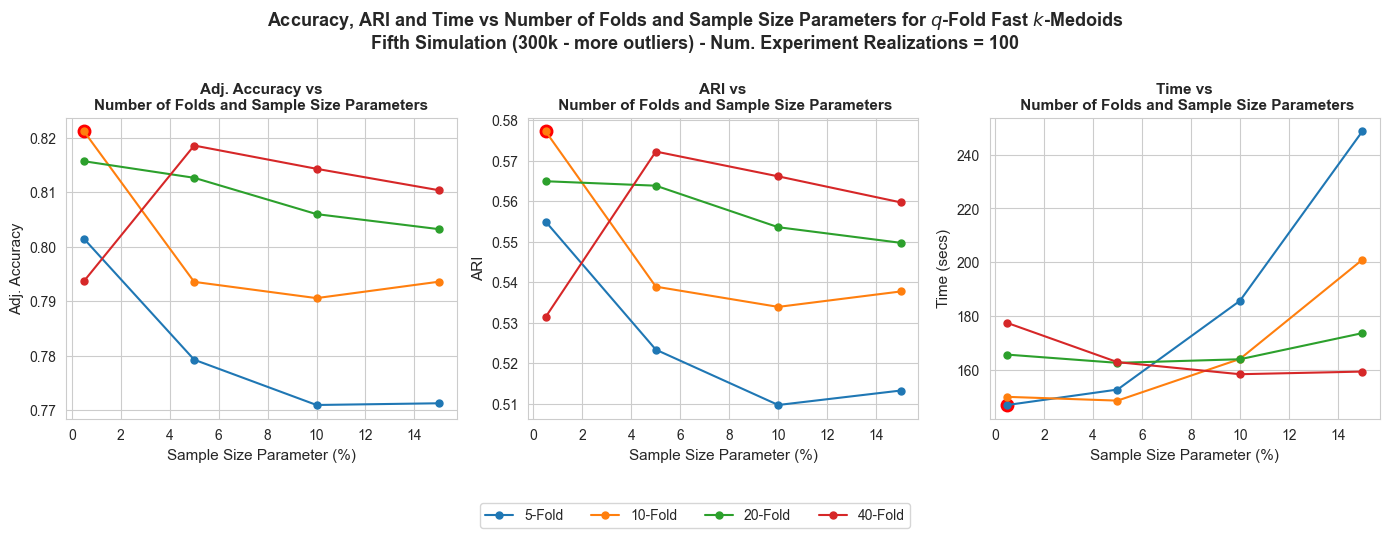

In [5]:
best_combi_acc = dfs['adj_accuracy'].sort_values(by='adj_accuracy', ascending=False).iloc[0]
best_combi_ari = dfs['ARI'].sort_values(by='ARI', ascending=False).iloc[0]
best_combi_time = dfs['time'].sort_values(by='time', ascending=True).iloc[0]

fig, axes = plt.subplots(1, 3, figsize=(14, 5.5), sharex=True)

# Primer subplot: Accuracy
ax1 = axes[0]
ax1.plot(best_combi_acc['frac_sample_sizes'] * 100, best_combi_acc['adj_accuracy'], marker='o', markersize=9, color='red')
for k1 in sorted(dfs['adj_accuracy']['n_splits'].unique()):
    subset = dfs['adj_accuracy'][dfs['adj_accuracy']['n_splits'] == k1]
    ax1.plot(subset['frac_sample_sizes'] * 100, subset['adj_accuracy'], marker='o', markersize=5, label=f"{k1}-Fold")
ax1.set_title("Adj. Accuracy vs\nNumber of Folds and Sample Size Parameters", fontsize=11, fontweight='bold')
ax1.set_xlabel("Sample Size Parameter (%)", size=11)
ax1.set_ylabel("Adj. Accuracy", size=11)

# Segundo subplot: Accuracy
ax2 = axes[1]
ax2.plot(best_combi_ari['frac_sample_sizes'] * 100, best_combi_ari['ARI'], marker='o', markersize=9, color='red')
for k1 in sorted(dfs['ARI']['n_splits'].unique()):
    subset = dfs['ARI'][dfs['ARI']['n_splits'] == k1]
    ax2.plot(subset['frac_sample_sizes'] * 100, subset['ARI'], marker='o', markersize=5, label=f"{k1}-Fold")
ax2.set_title("ARI vs\n Number of Folds and Sample Size Parameters", fontsize=11, fontweight='bold')
ax2.set_xlabel("Sample Size Parameter (%)", size=11)
ax2.set_ylabel("ARI", size=11)

# Tercer subplot: Time
ax3 = axes[2]
ax3.plot(best_combi_time['frac_sample_sizes'] * 100, best_combi_time['time'], marker='o', markersize=9, color='red')
for k1 in sorted(dfs['time']['n_splits'].unique()):
    subset = dfs['time'][dfs['time']['n_splits'] == k1]
    ax3.plot(subset['frac_sample_sizes'] * 100, subset['time'], marker='o', markersize=5, label=f"{k1}-Fold")
ax3.set_title("Time vs\n Number of Folds and Sample Size Parameters", fontsize=11, fontweight='bold')
ax3.set_xlabel("Sample Size Parameter (%)", size=11)
ax3.set_ylabel("Time (secs)", size=11)

# Título general
fig.suptitle("Accuracy, ARI and Time vs Number of Folds and Sample Size Parameters for $q$-Fold Fast $k$-Medoids\nFifth Simulation (300k - more outliers) - Num. Experiment Realizations = 100", fontsize=13, fontweight='bold', y=0.95)

# Leyenda común abajo
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=len(labels), fontsize=10)

plt.tight_layout(rect=[0, 0.1, 1, 0.95])

plot_filename = f'plot_results_exp_3_simu_6_{file_id}.png'
plot_save_path = os.path.join(results_folder_path, plot_filename)
fig.savefig(plot_save_path, format='png', dpi=300, bbox_inches="tight", pad_inches=0.2)

plt.show()


In [14]:
# Results as table
avg_results_df = pd.concat([dfs['adj_accuracy'], dfs['ARI']['ARI'], dfs['time']['time']], axis=1)
avg_results_df

,n_splits,frac_sample_sizes,adj_accuracy,ARI,time
0,5,0.005,0.801460,0.554921,146.924119
1,5,0.050,0.779259,0.523304,152.660294
2,5,0.100,0.770937,0.509633,185.641044
3,5,0.150,0.771251,0.513197,248.637901
4,10,0.005,0.821191,0.577205,149.951333
5,10,0.050,0.793557,0.538864,148.550570
6,10,0.100,0.790571,0.533867,164.030212
7,10,0.150,0.793587,0.537673,200.910989
8,20,0.005,0.815720,0.564907,165.654596
9,20,0.050,0.812677,0.563808,162.595182


In [13]:
best_frac_sample_size = dfs['adj_accuracy'].sort_values(by='adj_accuracy', ascending=False).iloc[0]['frac_sample_sizes']
best_n_splits = dfs['adj_accuracy'].sort_values(by='adj_accuracy', ascending=False).iloc[0]['n_splits']
n = len(X)
split_ratio = np.round((best_n_splits/n)*100,3) # best_split = split_ratio * n

print(' split_ratio', split_ratio, '\n', 'best_n_splits', best_n_splits, '\n', 'best_frac_sample_size', best_frac_sample_size)

 split_ratio 0.003 
 best_n_splits 10.0 
 best_frac_sample_size 0.005


## Experiment 4: Empirical comparison to other existing algorithms (section 3.5)

In [2]:
run_experiment_4 = True

In [3]:
experiment_4_config = get_config_exp_4_sim_6()

quant_distances_names = ['robust_mahalanobis']
binary_distances_names = ['jaccard', 'sokal']
multiclass_distances_names = ['hamming']
robust_method = ['MAD', 'trimmed', 'winsorized']

GGower_distances_names = get_GGower_distances_names(quant_distances_names, binary_distances_names, multiclass_distances_names, robust_method)

#################################################################################################

models = {
    
    'KMeans': KMeans(
        n_clusters=experiment_4_config['n_clusters'], 
        random_state=experiment_4_config['random_state'], 
        init='k-means++', 
        n_init='auto', 
        max_iter=experiment_4_config['max_iter']),

    'CLARA': CLARA(n_clusters=experiment_4_config['n_clusters'], 
                   metric='euclidean'),

    'LDAKmeans': LDAKmeans(n_clusters=experiment_4_config['n_clusters']),

    'SubKmeans': SubKmeans(n_clusters=experiment_4_config['n_clusters']),

    'GaussianMixture': GaussianMixture(n_components=experiment_4_config['n_clusters'], 
                                       random_state=experiment_4_config['random_state']),

    'SpectralBiclustering': SpectralBiclustering(n_clusters=experiment_4_config['n_clusters']),

    'SpectralCoclustering': SpectralCoclustering(n_clusters=experiment_4_config['n_clusters']),

    'BisectingKMeans': BisectingKMeans(n_clusters=experiment_4_config['n_clusters'], 
                                       random_state=experiment_4_config['random_state'], 
                                       max_iter=experiment_4_config['max_iter']),

    'MiniBatchKMeans': MiniBatchKMeans(n_clusters=experiment_4_config['n_clusters'], 
                                       random_state=experiment_4_config['random_state'], 
                                       max_iter=experiment_4_config['max_iter'])
                                       
}

#################################################################################################

for d in GGower_distances_names:

    d1, d2, d3 = d.split('-')

    if 'robust' in d1:
        r = d1.split('_')[-1]
        d1 = '_'.join(d1.split('_')[:2])
        
    models[f'FastKmedoidsGGower-{d1}_{r}-{d2}-{d3}'] = FastKmedoidsGGower(
            n_clusters=experiment_4_config['n_clusters'], 
            method=experiment_4_config['method'], 
            init=experiment_4_config['init'], 
            max_iter=experiment_4_config['max_iter'], 
            random_state=experiment_4_config['random_state'],
            frac_sample_size=experiment_4_config['frac_sample_size'], 
            p1=experiment_4_config['p1'], 
            p2=experiment_4_config['p2'], 
            p3=experiment_4_config['p3'], 
            d1=d1, 
            d2=d2, 
            d3=d3, 
            robust_method=r, 
            alpha=experiment_4_config['alpha'], 
            epsilon=experiment_4_config['epsilon'], 
            n_iters=experiment_4_config['n_iters'],
            VG_sample_size=experiment_4_config['VG_sample_size'], 
            VG_n_samples=experiment_4_config['VG_n_samples']) 

    models[f'FoldFastKmedoidsGGower-{d1}_{r}-{d2}-{d3}'] = FoldFastKmedoidsGGower(
            n_clusters=experiment_4_config['n_clusters'], 
            method=experiment_4_config['method'], 
            init=experiment_4_config['init'], 
            max_iter=experiment_4_config['max_iter'], 
            random_state=experiment_4_config['random_state'],
            frac_sample_size=experiment_4_config['frac_sample_size'], 
            p1=experiment_4_config['p1'], 
            p2=experiment_4_config['p2'], 
            p3=experiment_4_config['p3'], 
            d1=d1, 
            d2=d2, 
            d3=d3, 
            robust_method=r, 
            alpha=experiment_4_config['alpha'], 
            epsilon=experiment_4_config['epsilon'], 
            n_iters=experiment_4_config['n_iters'],
            VG_sample_size=experiment_4_config['VG_sample_size'], 
            VG_n_samples=experiment_4_config['VG_n_samples'],
            n_splits=experiment_4_config['n_splits'], 
            shuffle=experiment_4_config['shuffle'], 
            kfold_random_state=experiment_4_config['kfold_random_state']) 
    
#################################################################################################

model_names = list(models.keys())

In [ ]:
if run_experiment_4: 
   
    n_realizations = 100
    experiment_random_state = 123 
    random.seed(experiment_random_state)
    random_state_list = random.sample(range(n_realizations*1000), n_realizations)

    chunk_size = 3
    random_state_list_chunks = split_list_in_chunks(random_state_list, chunk_size=chunk_size)

    results_folder_path = os.path.join(current_path, '..', 'results', 'results_experiment_4', 'simulation_6')
    os.makedirs(results_folder_path, exist_ok=True)
    #file_id = datetime.now(ZoneInfo("Europe/Madrid")).strftime('%Y%m%d_%H%M%S')
    file_id = "20250820_092759"

    for chunk_id, random_state_chunk in enumerate(tqdm(random_state_list_chunks, desc='chunks', unit='chunks'), start=0):
        print('chunk_id', chunk_id)
        print('random_state_chunk:', random_state_chunk)

        results = {}

        for random_state in random_state_chunk:
            print('random_state:', random_state)        

            X, y = get_simulation_6(
                random_state=random_state, 
                return_outlier_idx=False)
            
            results[random_state] = make_experiment_4(
                X=X, 
                y=y, 
                models=models)

        # Save results
        results_filename = f'results_exp_4_simu_6_chunk_{chunk_id}_{file_id}.pkl'
        results_save_path = os.path.join(results_folder_path, results_filename)
        with open(results_save_path, 'wb') as f:
            pickle.dump(results, f)

# Time 100 realizations: 
## IBiDat Server: 1370 + 481  mins =  hours 

chunks:   0%|          | 0/12 [00:00<?, ?chunks/s]

chunk_id 22
random_state_chunk: [68237, 87617, 54984]
random_state: 68237
KMeans
CLARA
LDAKmeans
SubKmeans
GaussianMixture
SpectralBiclustering
SpectralCoclustering
BisectingKMeans
MiniBatchKMeans
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:31<00:00,  9.18s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.26s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.23s/it]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:41<00:00, 10.16s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:42<00:00, 10.28s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:42<00:00, 10.26s/it]


random_state: 87617
KMeans
CLARA
LDAKmeans
SubKmeans
GaussianMixture
SpectralBiclustering
SpectralCoclustering
BisectingKMeans
MiniBatchKMeans
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:31<00:00,  9.15s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.26s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.23s/it]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:41<00:00, 10.13s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:42<00:00, 10.26s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:42<00:00, 10.23s/it]


random_state: 54984
KMeans
CLARA
LDAKmeans
SubKmeans
GaussianMixture
SpectralBiclustering
SpectralCoclustering
BisectingKMeans
MiniBatchKMeans
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.22s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:33<00:00,  9.33s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.29s/it]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:42<00:00, 10.22s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:43<00:00, 10.39s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:   8%|▊         | 1/12 [1:00:16<11:03:00, 3616.43s/chunks]

chunk_id 23
random_state_chunk: [49089, 66855, 4173]
random_state: 49089
KMeans
CLARA
LDAKmeans
SubKmeans
GaussianMixture
SpectralBiclustering
SpectralCoclustering
BisectingKMeans
MiniBatchKMeans
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:31<00:00,  9.18s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.29s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.27s/it]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:41<00:00, 10.20s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:42<00:00, 10.30s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:43<00:00, 10.31s/it]


random_state: 66855
KMeans
CLARA
LDAKmeans
SubKmeans
GaussianMixture
SpectralBiclustering
SpectralCoclustering
BisectingKMeans
MiniBatchKMeans
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:31<00:00,  9.14s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.27s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:33<00:00,  9.35s/it]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:41<00:00, 10.16s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:42<00:00, 10.29s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:42<00:00, 10.30s/it]


random_state: 4173
KMeans
CLARA
LDAKmeans
SubKmeans
GaussianMixture
SpectralBiclustering
SpectralCoclustering
BisectingKMeans
MiniBatchKMeans
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.20s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:33<00:00,  9.32s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.26s/it]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:42<00:00, 10.21s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:42<00:00, 10.28s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  17%|█▋        | 2/12 [2:00:35<10:03:01, 3618.17s/chunks]

chunk_id 24
random_state_chunk: [98850, 84600, 23784]
random_state: 98850
KMeans
CLARA
LDAKmeans
SubKmeans
GaussianMixture
SpectralBiclustering
SpectralCoclustering
BisectingKMeans
MiniBatchKMeans
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:33<00:00,  9.36s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:33<00:00,  9.31s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:33<00:00,  9.31s/it]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:42<00:00, 10.23s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:43<00:00, 10.34s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:43<00:00, 10.30s/it]


random_state: 84600
KMeans
CLARA
LDAKmeans
SubKmeans
GaussianMixture
SpectralBiclustering
SpectralCoclustering
BisectingKMeans
MiniBatchKMeans
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:31<00:00,  9.17s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.27s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.29s/it]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:42<00:00, 10.25s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:43<00:00, 10.30s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:42<00:00, 10.29s/it]


random_state: 23784
KMeans
CLARA
LDAKmeans
SubKmeans
GaussianMixture
SpectralBiclustering
SpectralCoclustering
BisectingKMeans
MiniBatchKMeans
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:31<00:00,  9.20s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.27s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.26s/it]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:42<00:00, 10.30s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:43<00:00, 10.39s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  25%|██▌       | 3/12 [3:01:49<9:06:31, 3643.49s/chunks] 

chunk_id 25
random_state_chunk: [95135, 10827, 63819]
random_state: 95135
KMeans
CLARA
LDAKmeans
SubKmeans
GaussianMixture
SpectralBiclustering
SpectralCoclustering
BisectingKMeans
MiniBatchKMeans
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.25s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.29s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.26s/it]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:41<00:00, 10.19s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:42<00:00, 10.27s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:42<00:00, 10.26s/it]


random_state: 10827
KMeans
CLARA
LDAKmeans
SubKmeans
GaussianMixture
SpectralBiclustering
SpectralCoclustering
BisectingKMeans
MiniBatchKMeans
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:31<00:00,  9.14s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.28s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.27s/it]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:41<00:00, 10.13s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:42<00:00, 10.27s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:42<00:00, 10.26s/it]


random_state: 63819
KMeans
CLARA
LDAKmeans
SubKmeans


/home/fabio/fabio_scielzo_ortiz/tasks/.venv/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/fabio/fabio_scielzo_ortiz/tasks/.venv/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


GaussianMixture
SpectralBiclustering
SpectralCoclustering
BisectingKMeans
MiniBatchKMeans
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:31<00:00,  9.18s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.28s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:33<00:00,  9.31s/it]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:41<00:00, 10.18s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:42<00:00, 10.29s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  33%|███▎      | 4/12 [4:02:37<8:06:01, 3645.14s/chunks]

chunk_id 26
random_state_chunk: [86255, 34326, 22298]
random_state: 86255
KMeans
CLARA
LDAKmeans
SubKmeans
GaussianMixture
SpectralBiclustering
SpectralCoclustering
BisectingKMeans
MiniBatchKMeans
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:33<00:00,  9.34s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:34<00:00,  9.45s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.27s/it]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:42<00:00, 10.23s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:42<00:00, 10.27s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:42<00:00, 10.26s/it]


random_state: 34326
KMeans
CLARA
LDAKmeans
SubKmeans
GaussianMixture
SpectralBiclustering
SpectralCoclustering
BisectingKMeans
MiniBatchKMeans
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.26s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.25s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.26s/it]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:41<00:00, 10.18s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:42<00:00, 10.28s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:42<00:00, 10.25s/it]


random_state: 22298
KMeans
CLARA
LDAKmeans
SubKmeans
GaussianMixture
SpectralBiclustering
SpectralCoclustering
BisectingKMeans
MiniBatchKMeans
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:31<00:00,  9.17s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.26s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.24s/it]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:41<00:00, 10.17s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:42<00:00, 10.26s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  42%|████▏     | 5/12 [5:02:58<7:04:17, 3636.72s/chunks]

chunk_id 27
random_state_chunk: [43896, 44160, 72640]
random_state: 43896
KMeans
CLARA
LDAKmeans
SubKmeans
GaussianMixture
SpectralBiclustering
SpectralCoclustering
BisectingKMeans
MiniBatchKMeans
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.21s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.25s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.23s/it]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:42<00:00, 10.20s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:43<00:00, 10.31s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:42<00:00, 10.23s/it]


random_state: 44160
KMeans
CLARA
LDAKmeans
SubKmeans
GaussianMixture
SpectralBiclustering
SpectralCoclustering
BisectingKMeans
MiniBatchKMeans
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:31<00:00,  9.15s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.25s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.25s/it]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:41<00:00, 10.16s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:42<00:00, 10.29s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:42<00:00, 10.26s/it]


random_state: 72640
KMeans
CLARA
LDAKmeans
SubKmeans
GaussianMixture
SpectralBiclustering
SpectralCoclustering
BisectingKMeans
MiniBatchKMeans
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:31<00:00,  9.16s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.26s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.25s/it]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:41<00:00, 10.17s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:42<00:00, 10.27s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  50%|█████     | 6/12 [6:03:25<6:03:20, 3633.43s/chunks]

chunk_id 28
random_state_chunk: [51274, 9606, 94779]
random_state: 51274
KMeans
CLARA
LDAKmeans
SubKmeans
GaussianMixture
SpectralBiclustering
SpectralCoclustering
BisectingKMeans
MiniBatchKMeans
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.21s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.27s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.27s/it]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:41<00:00, 10.19s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:42<00:00, 10.28s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:42<00:00, 10.28s/it]


random_state: 9606
KMeans
CLARA
LDAKmeans
SubKmeans
GaussianMixture
SpectralBiclustering
SpectralCoclustering
BisectingKMeans
MiniBatchKMeans
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:31<00:00,  9.13s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.23s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.22s/it]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:41<00:00, 10.13s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:42<00:00, 10.23s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:42<00:00, 10.22s/it]


random_state: 94779
KMeans
CLARA
LDAKmeans
SubKmeans
GaussianMixture
SpectralBiclustering
SpectralCoclustering
BisectingKMeans
MiniBatchKMeans
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:31<00:00,  9.17s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.26s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.24s/it]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:41<00:00, 10.18s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:42<00:00, 10.25s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  58%|█████▊    | 7/12 [7:04:14<5:03:11, 3638.36s/chunks]

chunk_id 29
random_state_chunk: [59869, 50810, 75126]
random_state: 59869
KMeans
CLARA
LDAKmeans
SubKmeans
GaussianMixture
SpectralBiclustering
SpectralCoclustering
BisectingKMeans
MiniBatchKMeans
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:31<00:00,  9.17s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.26s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:33<00:00,  9.31s/it]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:41<00:00, 10.17s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:42<00:00, 10.27s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:42<00:00, 10.28s/it]


random_state: 50810
KMeans
CLARA
LDAKmeans
SubKmeans
GaussianMixture
SpectralBiclustering
SpectralCoclustering
BisectingKMeans
MiniBatchKMeans
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.20s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.30s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.29s/it]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:43<00:00, 10.30s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:43<00:00, 10.31s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:42<00:00, 10.29s/it]


random_state: 75126
KMeans
CLARA
LDAKmeans
SubKmeans
GaussianMixture
SpectralBiclustering
SpectralCoclustering
BisectingKMeans
MiniBatchKMeans
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:31<00:00,  9.15s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.26s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.25s/it]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:41<00:00, 10.16s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:42<00:00, 10.28s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  67%|██████▋   | 8/12 [8:10:01<4:09:06, 3736.64s/chunks]

chunk_id 30
random_state_chunk: [44054, 2137, 24780]
random_state: 44054
KMeans
CLARA
LDAKmeans
SubKmeans
GaussianMixture
SpectralBiclustering
SpectralCoclustering
BisectingKMeans
MiniBatchKMeans
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:31<00:00,  9.17s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:33<00:00,  9.39s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.25s/it]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:41<00:00, 10.16s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:42<00:00, 10.24s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:42<00:00, 10.23s/it]


random_state: 2137
KMeans
CLARA
LDAKmeans
SubKmeans
GaussianMixture
SpectralBiclustering
SpectralCoclustering
BisectingKMeans
MiniBatchKMeans
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:31<00:00,  9.13s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.23s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.22s/it]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:41<00:00, 10.13s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:42<00:00, 10.22s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:42<00:00, 10.23s/it]


random_state: 24780
KMeans
CLARA
LDAKmeans
SubKmeans
GaussianMixture
SpectralBiclustering
SpectralCoclustering
BisectingKMeans
MiniBatchKMeans
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:31<00:00,  9.15s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.25s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.26s/it]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:41<00:00, 10.16s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:42<00:00, 10.26s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  75%|███████▌  | 9/12 [9:10:19<3:04:58, 3699.56s/chunks]

chunk_id 31
random_state_chunk: [76834, 11554, 82354]
random_state: 76834
KMeans
CLARA
LDAKmeans
SubKmeans
GaussianMixture
SpectralBiclustering
SpectralCoclustering
BisectingKMeans
MiniBatchKMeans
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:31<00:00,  9.14s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.25s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.25s/it]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:41<00:00, 10.16s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:42<00:00, 10.27s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:42<00:00, 10.26s/it]


random_state: 11554
KMeans
CLARA
LDAKmeans
SubKmeans
GaussianMixture
SpectralBiclustering
SpectralCoclustering
BisectingKMeans
MiniBatchKMeans
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:31<00:00,  9.14s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.26s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.24s/it]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:41<00:00, 10.13s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:42<00:00, 10.25s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:42<00:00, 10.24s/it]


random_state: 82354
KMeans
CLARA
LDAKmeans
SubKmeans
GaussianMixture
SpectralBiclustering
SpectralCoclustering
BisectingKMeans
MiniBatchKMeans
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:31<00:00,  9.15s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.23s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.23s/it]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:41<00:00, 10.16s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:42<00:00, 10.25s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  83%|████████▎ | 10/12 [10:11:10<2:02:48, 3684.46s/chunks]

chunk_id 32
random_state_chunk: [47646, 1681, 46126]
random_state: 47646
KMeans
CLARA
LDAKmeans
SubKmeans
GaussianMixture
SpectralBiclustering
SpectralCoclustering
BisectingKMeans
MiniBatchKMeans
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:31<00:00,  9.20s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.26s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.25s/it]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:41<00:00, 10.19s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:42<00:00, 10.26s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:42<00:00, 10.27s/it]


random_state: 1681
KMeans
CLARA
LDAKmeans
SubKmeans
GaussianMixture
SpectralBiclustering
SpectralCoclustering
BisectingKMeans
MiniBatchKMeans
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:31<00:00,  9.16s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.24s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.22s/it]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:41<00:00, 10.12s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:42<00:00, 10.24s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:42<00:00, 10.23s/it]


random_state: 46126
KMeans
CLARA
LDAKmeans
SubKmeans
GaussianMixture
SpectralBiclustering
SpectralCoclustering
BisectingKMeans
MiniBatchKMeans
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:31<00:00,  9.13s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.23s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.24s/it]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:41<00:00, 10.15s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:42<00:00, 10.24s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  92%|█████████▏| 11/12 [11:11:02<1:00:56, 3656.15s/chunks]

chunk_id 33
random_state_chunk: [30032]
random_state: 30032
KMeans
CLARA
LDAKmeans
SubKmeans
GaussianMixture
SpectralBiclustering
SpectralCoclustering
BisectingKMeans
MiniBatchKMeans
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:31<00:00,  9.13s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.22s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.23s/it]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:41<00:00, 10.12s/it]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:42<00:00, 10.24s/it]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks: 100%|██████████| 12/12 [11:31:02<00:00, 3455.19s/chunks]  


In [7]:
if run_experiment_4: 

    # Open results by chunk
    chunk_ids = range(len(random_state_list_chunks))
    results_folder_path = os.path.join(current_path, '..', 'results', 'results_experiment_4', 'simulation_6')
    results_chunk = {}
    file_id = '20250820_092759'
    
    for chunk_id in chunk_ids:
        results_filename = f'results_exp_4_simu_6_chunk_{chunk_id}_{file_id}.pkl'
        results_save_path = os.path.join(results_folder_path, results_filename)
        with open(results_save_path, 'rb') as f:
            results_chunk[chunk_id] = pickle.load(f)

    # Join results by chunks
    results = {}
    for i in chunk_ids:
        results.update(results_chunk[i])  

    # Save joined/merged results 
    results_filename = f'results_exp_4_simu_6_{file_id}.pkl'
    results_save_path = os.path.join(results_folder_path, results_filename)
    with open(results_save_path, 'wb') as f:
        pickle.dump(results, f)

In [5]:
# Open merged/joined results 
file_id = '20250820_092759'
results_filename = f'results_exp_4_simu_6_{file_id}.pkl'
results_folder_path = os.path.join(current_path, '..', '..', '..', 'results', 'results_experiment_4', 'simulation_5')
results_save_path = os.path.join(results_folder_path, results_filename)
with open(results_save_path, 'rb') as f:
    results = pickle.load(f)

---
---

In [2]:
experiment_4_config = get_config_exp_4_sim_6()

quant_distances_names = ['robust_mahalanobis']
binary_distances_names = ['jaccard', 'sokal']
multiclass_distances_names = ['hamming']
robust_method = ['MAD', 'trimmed', 'winsorized']

GGower_distances_names = get_GGower_distances_names(quant_distances_names, binary_distances_names, multiclass_distances_names, robust_method)

#################################################################################################

models = {}

for d in GGower_distances_names:

    d1, d2, d3 = d.split('-')

    if 'robust' in d1:
        r = d1.split('_')[-1]
        d1 = '_'.join(d1.split('_')[:2])
        
    models[f'FastKmedoidsGGower-{d1}_{r}-{d2}-{d3}'] = FastKmedoidsGGower(
            n_clusters=experiment_4_config['n_clusters'], 
            method=experiment_4_config['method'], 
            init=experiment_4_config['init'], 
            max_iter=experiment_4_config['max_iter'], 
            random_state=experiment_4_config['random_state'],
            frac_sample_size=experiment_4_config['frac_sample_size'], 
            p1=experiment_4_config['p1'], 
            p2=experiment_4_config['p2'], 
            p3=experiment_4_config['p3'], 
            d1=d1, 
            d2=d2, 
            d3=d3, 
            robust_method=r, 
            alpha=experiment_4_config['alpha'], 
            epsilon=experiment_4_config['epsilon'], 
            n_iters=experiment_4_config['n_iters'],
            VG_sample_size=experiment_4_config['VG_sample_size'], 
            VG_n_samples=experiment_4_config['VG_n_samples']) 

    models[f'FoldFastKmedoidsGGower-{d1}_{r}-{d2}-{d3}'] = FoldFastKmedoidsGGower(
            n_clusters=experiment_4_config['n_clusters'], 
            method=experiment_4_config['method'], 
            init=experiment_4_config['init'], 
            max_iter=experiment_4_config['max_iter'], 
            random_state=experiment_4_config['random_state'],
            frac_sample_size=experiment_4_config['frac_sample_size'], 
            p1=experiment_4_config['p1'], 
            p2=experiment_4_config['p2'], 
            p3=experiment_4_config['p3'], 
            d1=d1, 
            d2=d2, 
            d3=d3, 
            robust_method=r, 
            alpha=experiment_4_config['alpha'], 
            epsilon=experiment_4_config['epsilon'], 
            n_iters=experiment_4_config['n_iters'],
            VG_sample_size=experiment_4_config['VG_sample_size'], 
            VG_n_samples=experiment_4_config['VG_n_samples'],
            n_splits=experiment_4_config['n_splits'], 
            shuffle=experiment_4_config['shuffle'], 
            kfold_random_state=experiment_4_config['kfold_random_state']) 

In [6]:
if run_experiment_4: 
   
    n_realizations = 100
    experiment_random_state = 123 
    random.seed(experiment_random_state)
    random_state_list = random.sample(range(n_realizations*1000), n_realizations)

    chunk_size = 2
    random_state_list_chunks = split_list_in_chunks(random_state_list, chunk_size=chunk_size)

    results_folder_path = os.path.join(current_path, '..', '..', 'results', 'results_experiment_4', 'simulation_5')
    os.makedirs(results_folder_path, exist_ok=True)
    file_id = datetime.now(ZoneInfo("Europe/Madrid")).strftime('%Y%m%d_%H%M%S')
    file_id = '20251022_103911'

In [6]:
if run_experiment_4: 

    for chunk_id, random_state_chunk in enumerate(tqdm(random_state_list_chunks[31:], desc='chunks', unit='chunks'), start=31):
        print('chunk_id', chunk_id)
        print('random_state_chunk:', random_state_chunk)

        results = {}

        for random_state in random_state_chunk:
            print('random_state:', random_state)        

            X, y = get_simulation_6(
                random_state=random_state, 
                return_outlier_idx=False)
            
            results[random_state] = make_experiment_4(
                X=X, 
                y=y, 
                models=models)

        # Save results
        results_filename = f'new_results_exp_4_simu_6_chunk_{chunk_id}_{file_id}.pkl'
        results_save_path = os.path.join(results_folder_path, results_filename)
        with open(results_save_path, 'wb') as f:
            pickle.dump(results, f)


chunks:   0%|          | 0/19 [00:00<?, ?chunks/s]

chunk_id 31
random_state_chunk: [83670, 87380]
random_state: 83670
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:33<00:00,  9.36s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:33<00:00,  9.38s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:33<00:00,  9.39s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:43<00:00, 10.31s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:44<00:00, 10.40s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:43<00:00, 10.39s/it]


len y_pred: 3
random_state: 87380
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.22s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:35<00:00,  9.51s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:37<00:00,  9.70s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:44<00:00, 10.45s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:44<00:00, 10.45s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:47<00:00, 10.76s/it]


len y_pred: 3


chunks:   5%|▌         | 1/19 [39:30<11:51:04, 2370.23s/chunks]

chunk_id 32
random_state_chunk: [78185, 63718]
random_state: 78185
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:34<00:00,  9.42s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:37<00:00,  9.74s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:37<00:00,  9.79s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:44<00:00, 10.42s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:45<00:00, 10.52s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:45<00:00, 10.53s/it]


len y_pred: 3
random_state: 63718
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.29s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:39<00:00,  9.96s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:33<00:00,  9.38s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:43<00:00, 10.33s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:43<00:00, 10.39s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:44<00:00, 10.44s/it]


len y_pred: 3


chunks:  11%|█         | 2/19 [1:19:22<11:15:13, 2383.14s/chunks]

chunk_id 33
random_state_chunk: [68237, 87617]
random_state: 68237
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:34<00:00,  9.40s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:33<00:00,  9.35s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:33<00:00,  9.39s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:43<00:00, 10.34s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:44<00:00, 10.41s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:45<00:00, 10.53s/it]


len y_pred: 3
random_state: 87617
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.28s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:34<00:00,  9.41s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:35<00:00,  9.50s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:42<00:00, 10.29s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:44<00:00, 10.45s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:44<00:00, 10.46s/it]


len y_pred: 3


chunks:  16%|█▌        | 3/19 [1:58:45<10:33:06, 2374.13s/chunks]

chunk_id 34
random_state_chunk: [54984, 49089]
random_state: 54984
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.25s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:35<00:00,  9.56s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [02:11<00:00, 13.19s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:43<00:00, 10.36s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:49<00:00, 10.93s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:47<00:00, 10.70s/it]


len y_pred: 3
random_state: 49089
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:33<00:00,  9.38s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:33<00:00,  9.33s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:33<00:00,  9.34s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:43<00:00, 10.38s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:44<00:00, 10.42s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [01:44<00:00, 10.45s/it]


len y_pred: 3


chunks:  21%|██        | 4/19 [2:39:11<9:58:36, 2394.42s/chunks] 

chunk_id 35
random_state_chunk: [66855, 4173]
random_state: 66855
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [01:32<00:00,  9.26s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [02:22<00:00, 14.23s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [02:39<00:00, 15.92s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [02:48<00:00, 16.81s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [02:46<00:00, 16.64s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [02:40<00:00, 16.00s/it]


len y_pred: 3
random_state: 4173
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [02:39<00:00, 15.91s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [02:46<00:00, 16.67s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [02:26<00:00, 14.70s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [02:55<00:00, 17.53s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [02:45<00:00, 16.58s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [02:50<00:00, 17.10s/it]


len y_pred: 3


chunks:  26%|██▋       | 5/19 [3:39:38<11:02:27, 2839.12s/chunks]

chunk_id 36
random_state_chunk: [98850, 84600]
random_state: 98850
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [02:20<00:00, 14.08s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [02:18<00:00, 13.82s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [02:30<00:00, 15.04s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [02:52<00:00, 17.21s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [02:52<00:00, 17.27s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [02:49<00:00, 16.97s/it]


len y_pred: 3
random_state: 84600
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [02:31<00:00, 15.16s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [02:38<00:00, 15.80s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [02:34<00:00, 15.49s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [02:50<00:00, 17.05s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [02:54<00:00, 17.41s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [02:57<00:00, 17.70s/it]


len y_pred: 3


chunks:  32%|███▏      | 6/19 [4:43:42<11:29:09, 3180.74s/chunks]

chunk_id 37
random_state_chunk: [23784, 95135]
random_state: 23784
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [02:42<00:00, 16.20s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [02:39<00:00, 15.93s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [02:36<00:00, 15.66s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [02:54<00:00, 17.49s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [02:58<00:00, 17.89s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [02:53<00:00, 17.40s/it]


len y_pred: 3
random_state: 95135
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [02:42<00:00, 16.26s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [02:35<00:00, 15.51s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [02:45<00:00, 16.54s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [02:55<00:00, 17.60s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [02:53<00:00, 17.35s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [02:57<00:00, 17.75s/it]


len y_pred: 3


chunks:  37%|███▋      | 7/19 [5:50:28<11:30:04, 3450.41s/chunks]

chunk_id 38
random_state_chunk: [10827, 63819]
random_state: 10827
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [02:37<00:00, 15.75s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [02:36<00:00, 15.66s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [02:31<00:00, 15.11s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [02:57<00:00, 17.76s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [02:53<00:00, 17.37s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [02:55<00:00, 17.59s/it]


len y_pred: 3
random_state: 63819
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [02:38<00:00, 15.87s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [02:40<00:00, 16.02s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [02:40<00:00, 16.05s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [03:13<00:00, 19.36s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [02:48<00:00, 16.85s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [02:52<00:00, 17.28s/it]


len y_pred: 3


chunks:  42%|████▏     | 8/19 [6:56:41<11:03:06, 3616.92s/chunks]

chunk_id 39
random_state_chunk: [86255, 34326]
random_state: 86255
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [02:33<00:00, 15.31s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [02:39<00:00, 15.98s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [02:32<00:00, 15.20s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [02:48<00:00, 16.86s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [02:57<00:00, 17.71s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [03:00<00:00, 18.01s/it]


len y_pred: 3
random_state: 34326
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [02:35<00:00, 15.50s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [02:38<00:00, 15.87s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [02:35<00:00, 15.52s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [02:56<00:00, 17.62s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [02:51<00:00, 17.18s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [02:52<00:00, 17.30s/it]


len y_pred: 3


chunks:  47%|████▋     | 9/19 [8:02:22<10:19:40, 3718.10s/chunks]

chunk_id 40
random_state_chunk: [22298, 43896]
random_state: 22298
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [02:35<00:00, 15.51s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [02:37<00:00, 15.79s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [02:39<00:00, 15.92s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [02:51<00:00, 17.17s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [02:51<00:00, 17.13s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [03:01<00:00, 18.11s/it]


len y_pred: 3
random_state: 43896
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [02:40<00:00, 16.01s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [02:39<00:00, 15.91s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [02:42<00:00, 16.25s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [02:54<00:00, 17.42s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [02:57<00:00, 17.73s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [02:53<00:00, 17.33s/it]


len y_pred: 3


chunks:  53%|█████▎    | 10/19 [9:08:26<9:29:05, 3793.92s/chunks]

chunk_id 41
random_state_chunk: [44160, 72640]
random_state: 44160
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [02:32<00:00, 15.24s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [02:36<00:00, 15.62s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [02:37<00:00, 15.77s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [02:48<00:00, 16.85s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [02:48<00:00, 16.82s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [02:52<00:00, 17.29s/it]


len y_pred: 3
random_state: 72640
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [02:36<00:00, 15.69s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [02:41<00:00, 16.19s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [02:37<00:00, 15.78s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [02:54<00:00, 17.47s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [02:51<00:00, 17.11s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [02:46<00:00, 16.70s/it]


len y_pred: 3


chunks:  58%|█████▊    | 11/19 [10:13:38<8:30:40, 3830.09s/chunks]

chunk_id 42
random_state_chunk: [51274, 9606]
random_state: 51274
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [02:37<00:00, 15.75s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [02:34<00:00, 15.43s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [02:34<00:00, 15.48s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [02:47<00:00, 16.75s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [02:53<00:00, 17.34s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [02:57<00:00, 17.77s/it]


len y_pred: 3
random_state: 9606
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [02:33<00:00, 15.35s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [02:43<00:00, 16.33s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [02:34<00:00, 15.45s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [02:51<00:00, 17.13s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [02:46<00:00, 16.65s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [02:50<00:00, 17.06s/it]


len y_pred: 3


chunks:  63%|██████▎   | 12/19 [11:19:04<7:30:15, 3859.30s/chunks]

chunk_id 43
random_state_chunk: [94779, 59869]
random_state: 94779
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [02:34<00:00, 15.50s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [02:45<00:00, 16.52s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [02:41<00:00, 16.15s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [02:57<00:00, 17.75s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [02:54<00:00, 17.48s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [03:03<00:00, 18.39s/it]


len y_pred: 3
random_state: 59869
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [02:42<00:00, 16.21s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [02:48<00:00, 16.82s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [02:43<00:00, 16.38s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [02:49<00:00, 16.95s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [02:54<00:00, 17.44s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [02:59<00:00, 17.97s/it]


len y_pred: 3


chunks:  68%|██████▊   | 13/19 [12:26:16<6:31:10, 3911.74s/chunks]

chunk_id 44
random_state_chunk: [50810, 75126]
random_state: 50810
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [02:40<00:00, 16.02s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [02:34<00:00, 15.41s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [02:38<00:00, 15.89s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [02:52<00:00, 17.29s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [02:52<00:00, 17.24s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [03:01<00:00, 18.10s/it]


len y_pred: 3
random_state: 75126
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [02:33<00:00, 15.38s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [02:39<00:00, 15.97s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [02:34<00:00, 15.45s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [03:01<00:00, 18.15s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [02:49<00:00, 16.95s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [02:48<00:00, 16.85s/it]


len y_pred: 3


chunks:  74%|███████▎  | 14/19 [13:32:34<5:27:37, 3931.59s/chunks]

chunk_id 45
random_state_chunk: [44054, 2137]
random_state: 44054
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [02:34<00:00, 15.44s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [02:45<00:00, 16.53s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [02:40<00:00, 16.05s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [02:52<00:00, 17.23s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [02:59<00:00, 17.90s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [02:53<00:00, 17.37s/it]


len y_pred: 3
random_state: 2137
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [02:40<00:00, 16.00s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [02:40<00:00, 16.05s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [02:33<00:00, 15.38s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [02:52<00:00, 17.22s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [02:52<00:00, 17.26s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [02:56<00:00, 17.63s/it]


len y_pred: 3


chunks:  79%|███████▉  | 15/19 [14:38:59<4:23:10, 3947.65s/chunks]

chunk_id 46
random_state_chunk: [24780, 76834]
random_state: 24780
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [02:34<00:00, 15.41s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [02:40<00:00, 16.04s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [02:35<00:00, 15.51s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [02:49<00:00, 16.95s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [02:52<00:00, 17.27s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [02:57<00:00, 17.75s/it]


len y_pred: 3
random_state: 76834
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [02:32<00:00, 15.29s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [02:33<00:00, 15.39s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [02:35<00:00, 15.55s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [02:49<00:00, 16.94s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [02:51<00:00, 17.14s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [02:52<00:00, 17.30s/it]


len y_pred: 3


chunks:  84%|████████▍ | 16/19 [15:44:39<3:17:16, 3945.33s/chunks]

chunk_id 47
random_state_chunk: [11554, 82354]
random_state: 11554
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [02:36<00:00, 15.60s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [02:38<00:00, 15.81s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [02:37<00:00, 15.75s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [02:51<00:00, 17.16s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [02:53<00:00, 17.38s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [02:48<00:00, 16.84s/it]


len y_pred: 3
random_state: 82354
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [02:39<00:00, 15.92s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [02:38<00:00, 15.86s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [02:35<00:00, 15.50s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [02:52<00:00, 17.28s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [02:54<00:00, 17.46s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [02:55<00:00, 17.52s/it]


len y_pred: 3


chunks:  89%|████████▉ | 17/19 [16:49:58<2:11:15, 3937.50s/chunks]

chunk_id 48
random_state_chunk: [47646, 1681]
random_state: 47646
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [02:36<00:00, 15.65s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [02:36<00:00, 15.67s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [02:37<00:00, 15.80s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [02:56<00:00, 17.69s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [02:47<00:00, 16.71s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [02:53<00:00, 17.35s/it]


len y_pred: 3
random_state: 1681
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [02:41<00:00, 16.15s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [02:45<00:00, 16.59s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [02:42<00:00, 16.26s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [02:49<00:00, 16.94s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [02:50<00:00, 17.05s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [02:53<00:00, 17.39s/it]


len y_pred: 3


chunks:  95%|█████████▍| 18/19 [17:56:28<1:05:53, 3953.27s/chunks]

chunk_id 49
random_state_chunk: [46126, 30032]
random_state: 46126
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [02:35<00:00, 15.50s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [02:35<00:00, 15.56s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [02:36<00:00, 15.61s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [02:45<00:00, 16.52s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [02:48<00:00, 16.88s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [02:46<00:00, 16.65s/it]


len y_pred: 3
random_state: 30032
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [02:33<00:00, 15.31s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [02:30<00:00, 15.02s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 10/10 [02:31<00:00, 15.19s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [02:50<00:00, 17.05s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [02:50<00:00, 17.05s/it]


len y_pred: 3
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 3
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 10/10 [02:49<00:00, 16.99s/it]


len y_pred: 3


chunks: 100%|██████████| 19/19 [19:01:06<00:00, 3603.48s/chunks]  


In [7]:
if run_experiment_4: 

    # Open results by chunk
    chunk_ids = range(len(random_state_list_chunks))
    results_folder_path = os.path.join(current_path, '..', '..', 'results', 'results_experiment_4', 'simulation_5')
    results_chunk = {}
    for chunk_id in chunk_ids:        
        results_filename = f'new_results_exp_4_simu_6_chunk_{chunk_id}_{file_id}.pkl'
        results_save_path = os.path.join(results_folder_path, results_filename)
        with open(results_save_path, 'rb') as f:
            results_chunk[chunk_id] = pickle.load(f)

    # Join results by chunks
    results = {}
    for i in chunk_ids:
        results.update(results_chunk[i])  

    # Save joined/merged new results 
    results_filename = f'new_results_exp_4_simu_6_{file_id}.pkl'
    results_save_path = os.path.join(results_folder_path, results_filename)
    with open(results_save_path, 'wb') as f:
        pickle.dump(results, f)

In [8]:
# Open merged/joined new results 
file_id = '20251022_103911'
results_filename = f'new_results_exp_4_simu_6_{file_id}.pkl'
results_folder_path = os.path.join(current_path, '..', '..', 'results', 'results_experiment_4', 'simulation_5')
results_save_path = os.path.join(results_folder_path, results_filename)
with open(results_save_path, 'rb') as f:
    new_results = pickle.load(f)

In [9]:
# Open merged/joined results 
file_id = '20250820_092759'
results_filename = f'results_exp_4_simu_6_{file_id}.pkl'
results_save_path = os.path.join(results_folder_path, results_filename)
with open(results_save_path, 'rb') as f:
    results = pickle.load(f)

In [10]:
def update_results(results, new_results):

    for random_state in new_results.keys():
        for metric in new_results[random_state].keys():
            results[random_state][metric].update(new_results[random_state][metric])

In [11]:
update_results(results, new_results)

---
---

In [12]:
pivoted_results = get_pivoted_results(
    results=results, 
    iterable=model_names
)

avg_results = get_avg_results(
    results=results, 
    pivoted_results=pivoted_results, 
    iterable=model_names
)

In [13]:
avg_results['std_adj_acc'] = {k: np.std(pivoted_results['adj_accuracy'][k]) for k in model_names}
avg_results['std_ARI'] = {k: np.std(pivoted_results['ARI'][k]) for k in model_names}
avg_results['std_time'] = {k: np.std(pivoted_results['time'][k]) for k in model_names}

In [14]:
not_feasible_methods = ['DipInit', 'Spectral-Clustering', 'KMedoids-euclidean', 'Diana', 'AgglomerativeClustering', 'Birch'] # based on previous (TFM) experiments

for model_name in not_feasible_methods:
    avg_results['adj_labels'][model_name] = None
    avg_results['labels'][model_name] = None
    avg_results['adj_accuracy'][model_name] = 0
    avg_results['ARI'][model_name] = 0
    avg_results['time'][model_name] = 0
    avg_results['std_adj_acc'][model_name] = 0
    avg_results['std_ARI'][model_name] = 0
    avg_results['std_time'][model_name] = 0

model_names = np.array(list(avg_results['adj_accuracy'].keys()))
avg_adj_accuracy = np.array(list(avg_results['adj_accuracy'].values()))
avg_ari = np.array(list(avg_results['ARI'].values()))
avg_time = np.array(list(avg_results['time'].values()))
std_adj_acc = np.array(list(avg_results['std_adj_acc'].values()))
std_ari = np.array(list(avg_results['std_ARI'].values()))
std_time = np.array(list(avg_results['std_time'].values()))
idx_sorted = np.argsort(-avg_adj_accuracy) 
#idx_sorted = np.argsort(-avg_ari) 

our_methods_1 = [x for x in model_names if 'Fast' in x and 'Fold' not in x] # Fast k-medoids
our_methods_2 = [x for x in model_names if 'Fast' in x and 'Fold' in x] # q-Fold Fast k-medoids
other_methods = [x for x in model_names if x not in our_methods_1 + our_methods_2 and x not in not_feasible_methods]

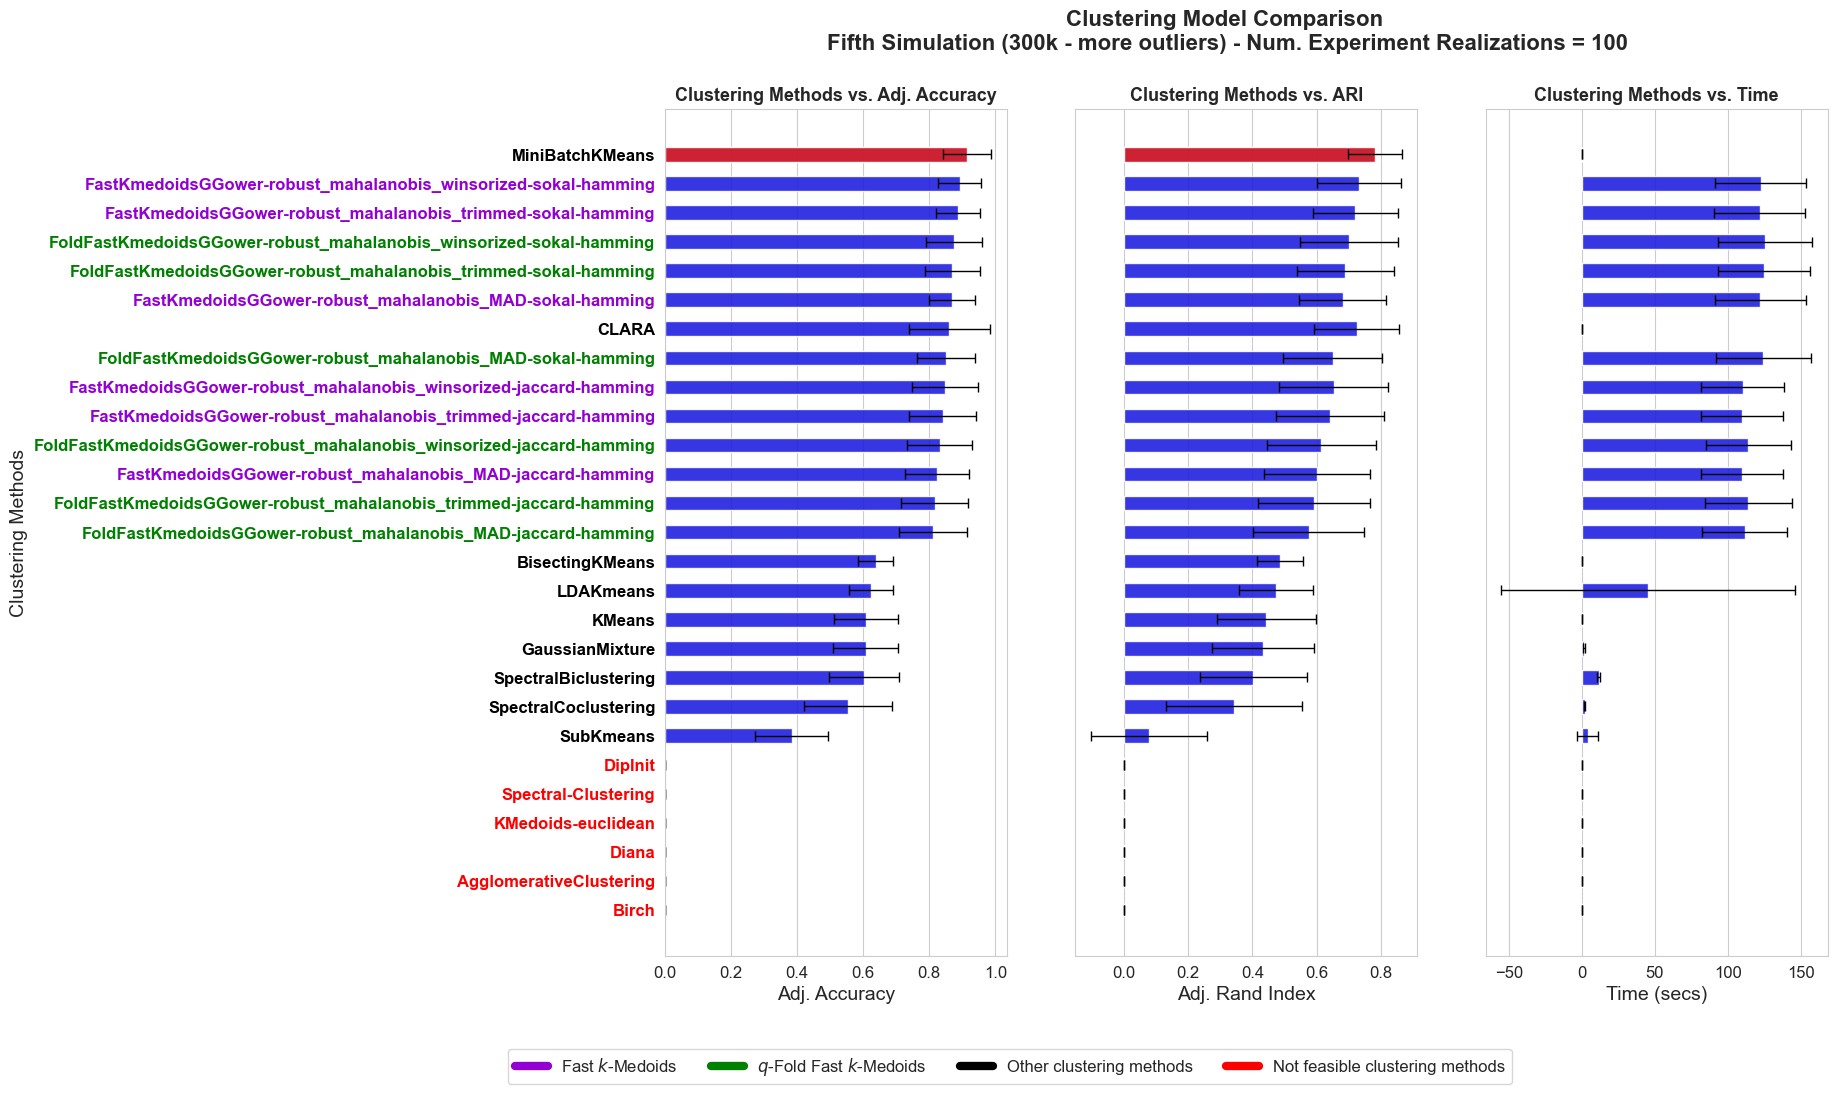

In [16]:
fig, axes = plt.subplots(1,3, figsize=(15,11))
axes = axes.flatten()

ax = sns.barplot(x=avg_adj_accuracy[idx_sorted], y=model_names[idx_sorted], color='blue', width=0.5, alpha=0.9, ax=axes[0])
ax = sns.barplot(x=[avg_adj_accuracy[idx_sorted[0]]], y=[model_names[idx_sorted[0]]], color='red', width=0.5, alpha=0.9, ax=axes[0])

ax = sns.barplot(x=avg_ari[idx_sorted], y=model_names[idx_sorted], color='blue', width=0.5, alpha=0.9, ax=axes[1])
ax = sns.barplot(x=[avg_ari[idx_sorted[0]]], y=[model_names[idx_sorted[0]]], color='red', width=0.5, alpha=0.9, ax=axes[1])

ax = sns.barplot(x=avg_time[idx_sorted], y=model_names[idx_sorted], color='blue', width=0.5, alpha=0.9, ax=axes[2])
ax = sns.barplot(x=[avg_time[idx_sorted[0]]], y=[model_names[idx_sorted[0]]], color='red', width=0.5, alpha=0.9, ax=axes[2])

# Añadir barras de error manualmente
axes[0].errorbar(
    x=avg_adj_accuracy[idx_sorted],
    y=np.arange(len(model_names[idx_sorted])),
    xerr=std_adj_acc[idx_sorted],
    fmt='none',                # no dibuja puntos extra
    ecolor='black',            # color de las líneas de error
    elinewidth=1,            # grosor de las líneas
    capsize=3.5,                 # tamaño de los topes
    alpha=1
)

axes[1].errorbar(
    x=avg_ari[idx_sorted],
    y=np.arange(len(model_names[idx_sorted])),
    xerr=std_ari[idx_sorted],
    fmt='none',                # no dibuja puntos extra
    ecolor='black',            # color de las líneas de error
    elinewidth=1,            # grosor de las líneas
    capsize=3.5,                 # tamaño de los topes
    alpha=1
)

axes[2].errorbar(
    x=avg_time[idx_sorted],
    y=np.arange(len(model_names[idx_sorted])),
    xerr=std_time[idx_sorted],
    fmt='none',                # no dibuja puntos extra
    ecolor='black',            # color de las líneas de error
    elinewidth=1,            # grosor de las líneas
    capsize=3.5,                 # tamaño de los topes
    alpha=1
)

axes[0].set_ylabel('Clustering Methods', size=14)
axes[0].set_xlabel('Adj. Accuracy', size=14)
#axes[0].set_xticks(np.round(np.linspace(0, np.max(accuracy_list), 7),2)) 
axes[0].tick_params(axis='y', labelsize=12)    
axes[0].tick_params(axis='x', labelsize=12)  
axes[0].set_title('Clustering Methods vs. Adj. Accuracy', size=13, weight='bold')

axes[1].set_xlabel('Adj. Rand Index', size=14)
#axes[1].set_xticks(np.round(np.linspace(0, np.max(adj_rand_index_list), 7),2)) 
axes[1].tick_params(axis='x', labelsize=12)  
axes[1].set_title('Clustering Methods vs. ARI', size=13, weight='bold')
axes[1].set_yticklabels([])

axes[2].set_xlabel('Time (secs)', size=14)
#axes[2].set_xticks(np.round(np.linspace(0, np.max(time_list), 7),2)) 
axes[2].tick_params(axis='x', labelsize=12)  
axes[2].set_title('Clustering Methods vs. Time', size=13, weight='bold')
axes[2].set_yticklabels([])

for label in axes[0].get_yticklabels():
    if label.get_text() in our_methods_1:
        label.set_weight('bold')
        label.set_color('darkviolet') 
    elif label.get_text() in our_methods_2:
        label.set_weight('bold')
        label.set_color('green') 
    elif label.get_text() in other_methods:
        label.set_weight('bold')
        label.set_color('black') 
    elif label.get_text() in not_feasible_methods:
        label.set_weight('bold')
        label.set_color('red') 

# Create legend elements
legend_elements = [
    plt.Line2D([0], [0], color='darkviolet', lw=6, label='Fast $k$-Medoids'),
    plt.Line2D([0], [0], color='green', lw=6, label='$q$-Fold Fast $k$-Medoids'),
    plt.Line2D([0], [0], color='black', lw=6, label='Other clustering methods'),
    plt.Line2D([0], [0], color='red', lw=6, label='Not feasible clustering methods')
]

# Add legend to the figure
axes[0].legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(2.5, -0.1), ncol=len(legend_elements), fontsize=12)

fig.suptitle("Clustering Model Comparison \nFifth Simulation (300k - more outliers) - Num. Experiment Realizations = 100", fontsize=16, fontweight='bold', y=0.97)

plot_filename = f'plot_results_exp_4_simu_6_{file_id}_acc.png'
plot_save_path = os.path.join(results_folder_path, plot_filename)
fig.savefig(plot_save_path, format='png', dpi=300, bbox_inches="tight", pad_inches=0.2)

plt.show()

In [17]:
# Results as table 
avg_results_df = pd.DataFrame(avg_results)
avg_results_df.index.name = 'models'
avg_results_df = avg_results_df.drop(['labels', 'adj_labels'], axis=1)
avg_results_df_sorted_acc = avg_results_df.sort_values(by='adj_accuracy', ascending=False)
avg_results_df_sorted_ari = avg_results_df.sort_values(by='ARI', ascending=False)

In [18]:
avg_results_df_sorted_acc

,time,adj_accuracy,ARI,std_adj_acc,std_ARI,std_time
models,,,,,,
MiniBatchKMeans,0.157251,0.914336,0.780473,0.072011,0.084119,0.008634
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming,122.390240,0.892420,0.731352,0.065560,0.130425,31.374545
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming,121.956128,0.887454,0.720427,0.066489,0.132318,31.201595
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming,125.513105,0.874116,0.699609,0.084743,0.152393,32.197600
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming,124.645604,0.869503,0.688896,0.082811,0.151188,31.529872
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming,122.189008,0.868767,0.680341,0.070058,0.134262,31.274462
CLARA,0.303634,0.860646,0.724846,0.122378,0.132100,0.039825
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming,124.371938,0.850423,0.649024,0.087354,0.155264,32.361217
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming,110.300807,0.847579,0.652296,0.100263,0.168936,28.495023


In [19]:
avg_results_df_sorted_ari

,time,adj_accuracy,ARI,std_adj_acc,std_ARI,std_time
models,,,,,,
MiniBatchKMeans,0.157251,0.914336,0.780473,0.072011,0.084119,0.008634
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming,122.390240,0.892420,0.731352,0.065560,0.130425,31.374545
CLARA,0.303634,0.860646,0.724846,0.122378,0.132100,0.039825
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming,121.956128,0.887454,0.720427,0.066489,0.132318,31.201595
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming,125.513105,0.874116,0.699609,0.084743,0.152393,32.197600
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming,124.645604,0.869503,0.688896,0.082811,0.151188,31.529872
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming,122.189008,0.868767,0.680341,0.070058,0.134262,31.274462
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming,110.300807,0.847579,0.652296,0.100263,0.168936,28.495023
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming,124.371938,0.850423,0.649024,0.087354,0.155264,32.361217


---

In [32]:
random_state_mds = 4173 

X, y, outliers_idx = get_simulation_6(random_state=random_state_mds, return_outlier_idx=True)

mds = MDS(n_components=2, dissimilarity='precomputed', random_state=random_state_mds) 

fastGG = FastGGowerDistMatrix(frac_sample_size=0.005, random_state=100, p1=4, p2=2, p3=2, 
                 d1='robust_mahalanobis', d2='sokal', d3='hamming', 
                 robust_method='winsorized', alpha=0.05)

fastGG.compute(X)

X_mds = mds.fit_transform(fastGG.D_GGower)

# Time: 7 mins

c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


In [33]:
outliers_bool = np.array([0 if x not in outliers_idx else 1 for x in range(0, len(X))])

sorted_methods_accuracy = list(avg_results_df_sorted_acc.index)

our_methods_1_sorted_acc = [x for x in list(sorted_methods_accuracy) if x in our_methods_1]
our_methods_2_sorted_acc = [x for x in list(sorted_methods_accuracy) if x in our_methods_2]
other_methods_sorted_acc = [x for x in list(sorted_methods_accuracy) if x in other_methods]
best_our_methods_1 = our_methods_1_sorted_acc[0]
best_our_methods_2 = our_methods_2_sorted_acc[0]
best_other_methods = other_methods_sorted_acc[0]
additional_methods = ['KMeans', 'GaussianMixture']

methods_to_plot = [best_our_methods_1, best_our_methods_2, best_other_methods] + additional_methods
names_to_plot = [('Best Fast k-medoids' if x in our_methods_1 else 'Best q-Fold Fast k-medoids' if x in our_methods_2 else x) for x in methods_to_plot]
names_to_plot = dict(zip(methods_to_plot, names_to_plot))
y_pred_dict = {names_to_plot[method]: results[random_state_mds]['adj_labels'][method][fastGG.sample_index] for method in methods_to_plot}
accuracy_dict = {names_to_plot[method]: results[random_state_mds]['adj_accuracy'][method] for method in methods_to_plot}
time_dict = {names_to_plot[method]: results[random_state_mds]['time'][method] for method in methods_to_plot}


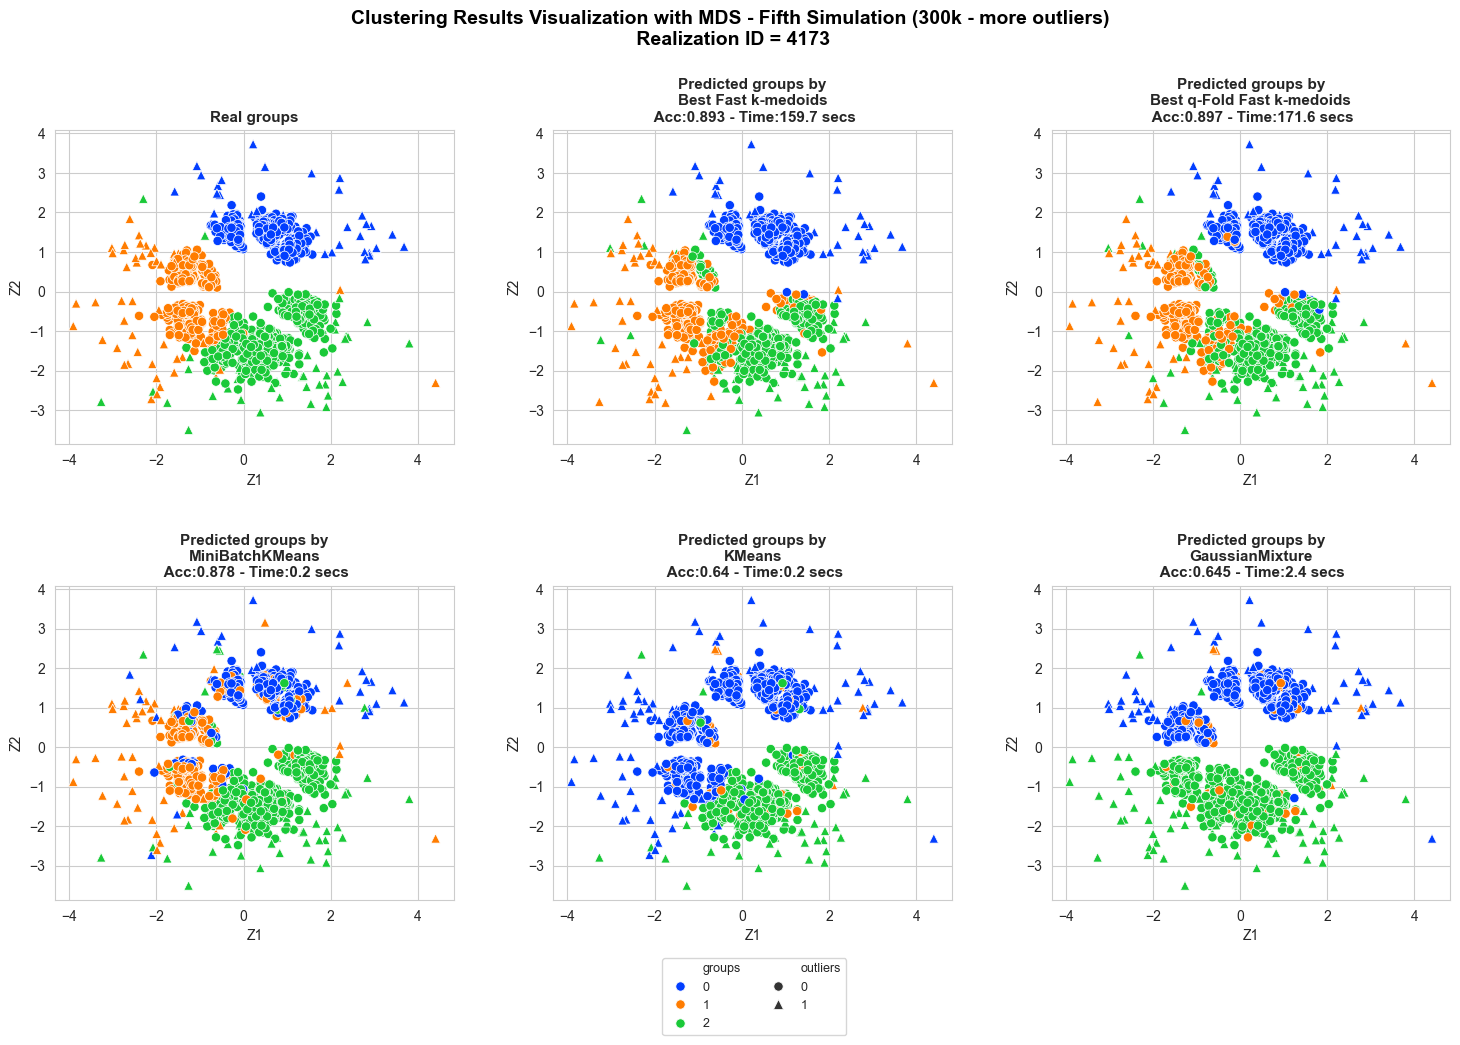

In [34]:
plot_filename = f'mds_plot_exp_4_simu_6_{file_id}.png'
results_folder_path = os.path.join(current_path, '..', '..', 'results', 'results_experiment_4', 'simulation_5')
plot_save_path = os.path.join(results_folder_path, plot_filename)

clustering_MDS_plot_multiple_methods(X_mds=X_mds, y_pred=y_pred_dict, 
                                     y_true=y[fastGG.sample_index],
                                     title=f"Clustering Results Visualization with MDS - Fifth Simulation (300k - more outliers)\n Realization ID = {random_state_mds}", 
                                     accuracy=accuracy_dict, time=time_dict, n_rows=2,
                                     figsize=(18,10), bbox_to_anchor=(0.75,-1.9), 
                                     title_size=14, title_weight='bold', 
                                     subtitles_size=11,
                                     points_size=45, title_height=1, 
                                     wspace=0.25, hspace=0.45, 
                                     outliers_boolean=outliers_bool[fastGG.sample_index],
                                     n_cols_legend=2, legend_title='', legend_size=9, 
                                     save = True, file_name = plot_save_path
)